# Cyber Bullying Classification Task on Twitter Database

## Exploratory Data Analysis

Firstly, we import our dataset and the necessary libraries.

In [1]:
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import ssl
import zipfile
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from tokenizers import Tokenizer
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers import decoders
from tokenizers.normalizers import Lowercase

from google.colab import drive

from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import datasets
from datasets import Dataset
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import ProgressCallback

import spacy
from collections import Counter
from wordcloud import WordCloud
import math
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import lil_matrix, vstack
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier as XGBoost
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

2025-06-23 19:38:04.983727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750707485.223856      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750707485.298351      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
file_path = "cyberbullying_tweets.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "andrewmvd/cyberbullying-classification",
  file_path,
)

/tmp/ipykernel_35/2032824817.py:3: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


We visualize the first 5 entries in our dataset.

In [3]:
df.shape

(47692, 2)

In [4]:
df.head(5)

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

We can see that the dataset is composed of 2 columns: tweets and the type of cyber bullying present in the tweet.

In [5]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

The target "cyberbullying_type" can take the following values:
- not_cyberbullying
- gender
- religion
- age
- ethnicity
- other_cyberbullying

We will use label encoding to encode our target values.

We first check for missing values and duplicate entries.

In [6]:
missing_text = df['tweet_text'].isna().sum()
print("Missing tweet_text entries:", missing_text)

Missing tweet_text entries: 0


Then, we lowercase all the tweets as shown below and check for duplicates.

In [7]:
df['clean_text'] = df['tweet_text'].str.strip().str.lower()
df['clean_text'].duplicated().sum()

1701

We discard the detected duplicates and check the dataset again:

In [8]:
df = df.drop_duplicates(subset='tweet_text', keep='first').reset_index(drop=True)

In [9]:
text_duplicates = df['tweet_text'].duplicated().sum()
print("Duplicate tweet_text entries:", text_duplicates)

Duplicate tweet_text entries: 0


In [10]:
df = df.reset_index(drop = True)

Now let's visualize the class balance.

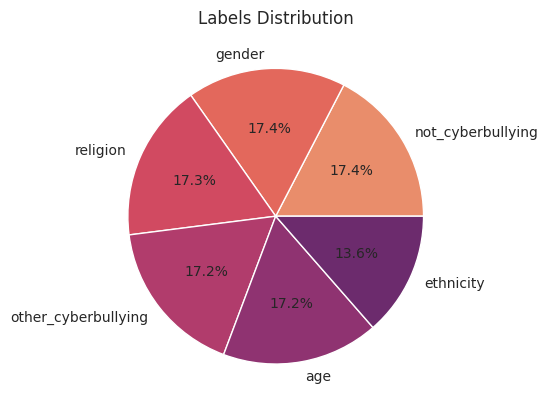

In [11]:
label_counts = df.cyberbullying_type.value_counts()
sns.set_style("darkgrid")
sns.set_palette('flare')
plt.figure()
plt.pie(x = label_counts, labels = df.cyberbullying_type.unique(),autopct = "%1.1f%%")
plt.title('Labels Distribution')
plt.show()



It can be seen that we have a mostly balanced distribution in our labels.

## Traditional NLP approach

## Pre - Processing

For preprocessing, we will mainly use the Spacy Library.

In [12]:
nlp = spacy.load("en_core_web_sm", disable = ['ner', 'parser'])

In [13]:
def spacy_tokenizer(text):
  doc = nlp(text)
  return [token.lemma_.lower() for token in doc if
          token.is_alpha and
          not token.is_stop and
          len(token.lemma_) >= 3
          ]

In [14]:
df['lemmas'] = df['tweet_text'].apply(spacy_tokenizer)
# Takes around 4 minutes

After cleaning the text, we can visualize the first few entries and the most common tokens in the dataset.

In [15]:
df[['tweet_text', 'lemmas']].head(5)

tweet_text  \
0  In other words #katandandre, your food was cra...   
1  Why is #aussietv so white? #MKR #theblock #ImA...   
2  @XochitlSuckkks a classy whore? Or more red ve...   
3  @Jason_Gio meh. :P  thanks for the heads up, b...   
4  @RudhoeEnglish This is an ISIS account pretend...   

                                              lemmas  
0       [word, katandandre, food, crapilicious, mkr]  
1  [aussietv, white, mkr, theblock, imacelebritya...  
2              [classy, whore, red, velvet, cupcake]  
3  [meh, thank, head, concerned, angry, dude, twi...  
4  [isis, account, pretend, kurdish, account, lik...

In [16]:
# prompt: create a list of most common lemmas, displayed as a table

from collections import Counter

# Flatten the list of lemmas
all_lemmas = [lemma for lemmas_list in df['lemmas'] for lemma in lemmas_list]

# Count the occurrences of each lemma
lemma_counts = Counter(all_lemmas)

# Get the most common lemmas
most_common_lemmas = lemma_counts.most_common(10)

# Convert to a pandas DataFrame for display
most_common_lemmas_df = pd.DataFrame(most_common_lemmas, columns=['Lemma', 'Count'])

# Display the table
print("Most Common Lemmas:")
most_common_lemmas_df

Most Common Lemmas:


Lemma  Count
0   bully  10732
1  school   9234
2    fuck   6772
3    like   6194
4  nigger   5555
5    girl   5529
6    joke   5484
7    dumb   5384
8    high   5312
9  people   4844

Moreover, we can check the total number of tokens and our vocabulary size, which is built from unique tokens.

In [17]:
total_tokens = df['lemmas'].apply(len).sum()
print("Total number of tokens:", total_tokens)

Total number of tokens: 506953


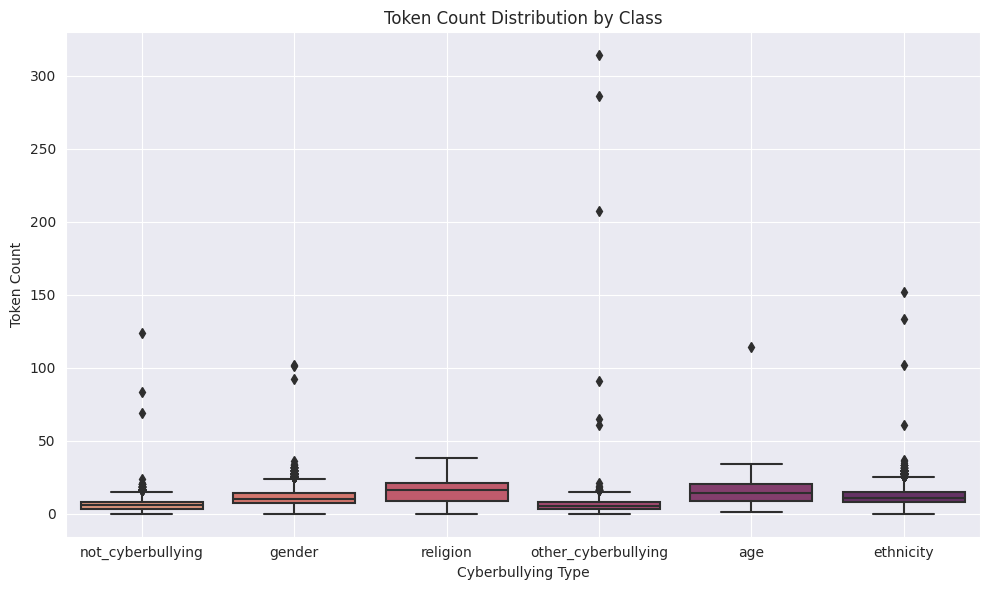

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate token count for each row
df['token_count'] = df['lemmas'].apply(len)

# Plot histogram of token counts by class
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cyberbullying_type', y='token_count')
plt.ylabel("Token Count")
plt.xlabel("Cyberbullying Type")
plt.title("Token Count Distribution by Class")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
vocab = set(token for doc in df['lemmas'] for token in doc)
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

Vocabulary size: 34432


Lastly, we can check for the average and maximum length of the posts in the database.

In [20]:
avg_tokens_per_doc = total_tokens / len(df)
print("Average tokens per document:", avg_tokens_per_doc)

Average tokens per document: 11.01664602212226


In [21]:
print("Max tokens in a doc:", df['lemmas'].apply(len).max())

Max tokens in a doc: 314


Now, we will create our word clouds for each class to see the most common words:

In [22]:
# turn into strings
df['clean_text'] = df['lemmas'].apply(lambda x: ' '.join(x))

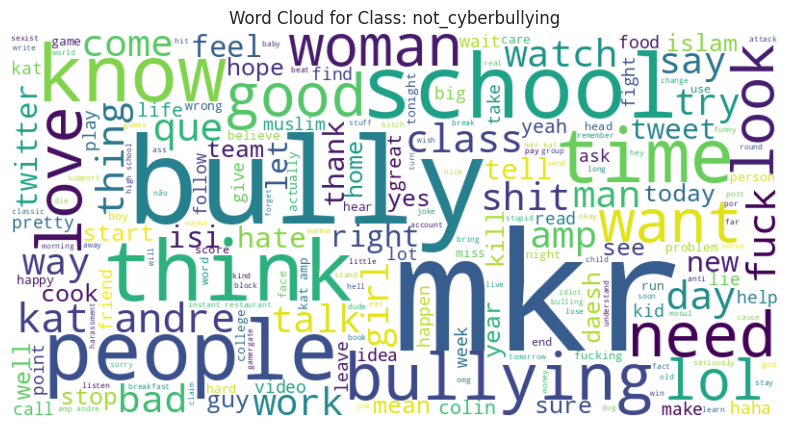

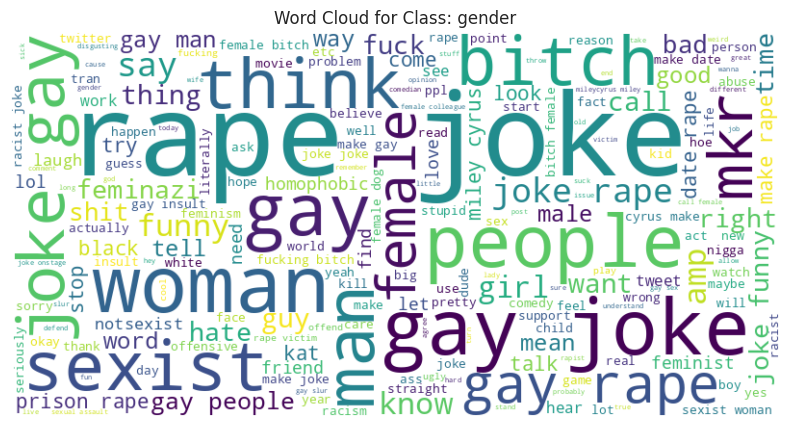

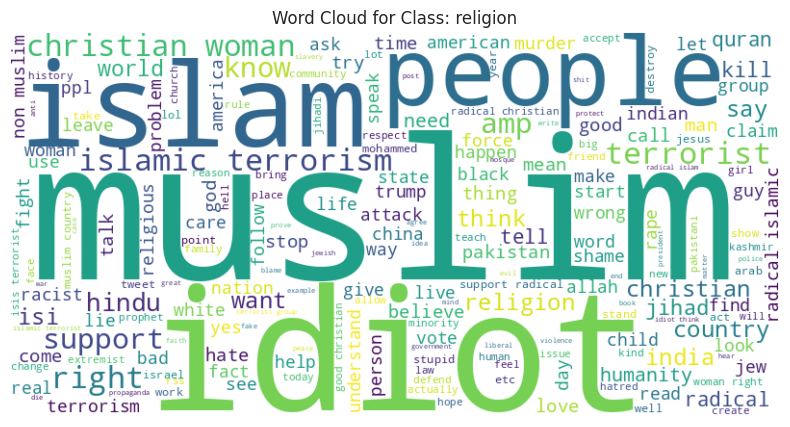

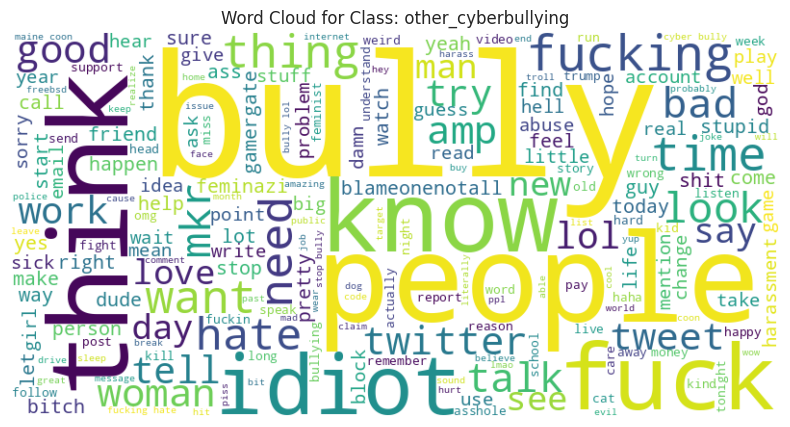

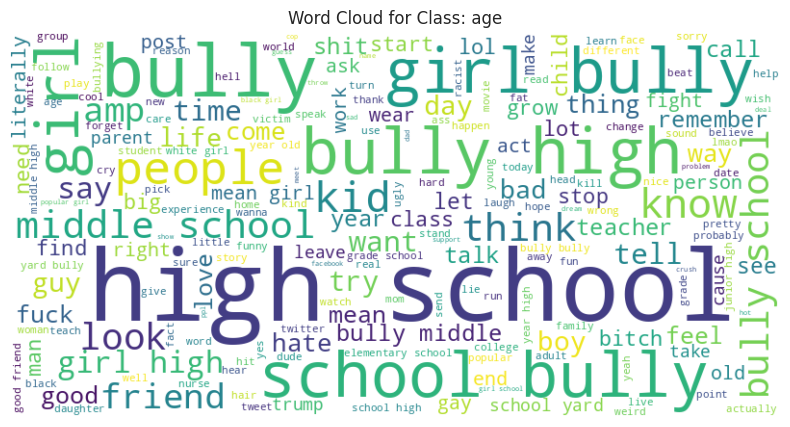

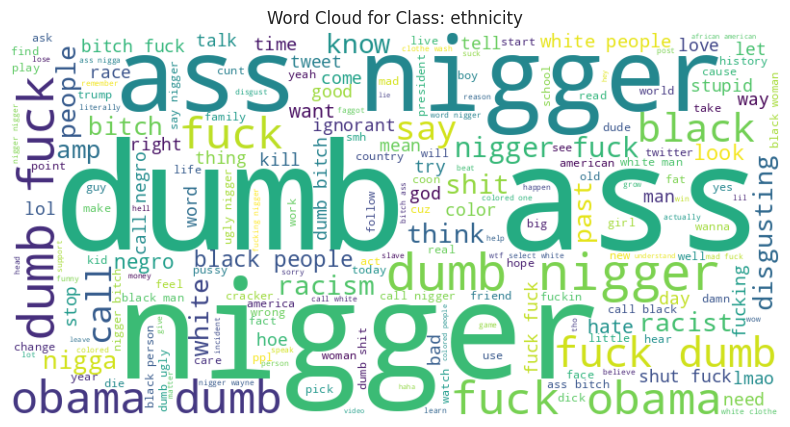

In [23]:
from wordcloud import WordCloud

# Define function to generate a word cloud for each class
def plot_wordclouds_per_class(df, text_col, label_col):
    labels = df[label_col].unique()
    for label in labels:
        text = ' '.join(df[df[label_col] == label][text_col])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Class: {label}")
        plt.show()

plot_wordclouds_per_class(df, text_col='clean_text', label_col='cyberbullying_type')

And we can visualize the top unigrams per category:

/tmp/ipykernel_35/2895860676.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)


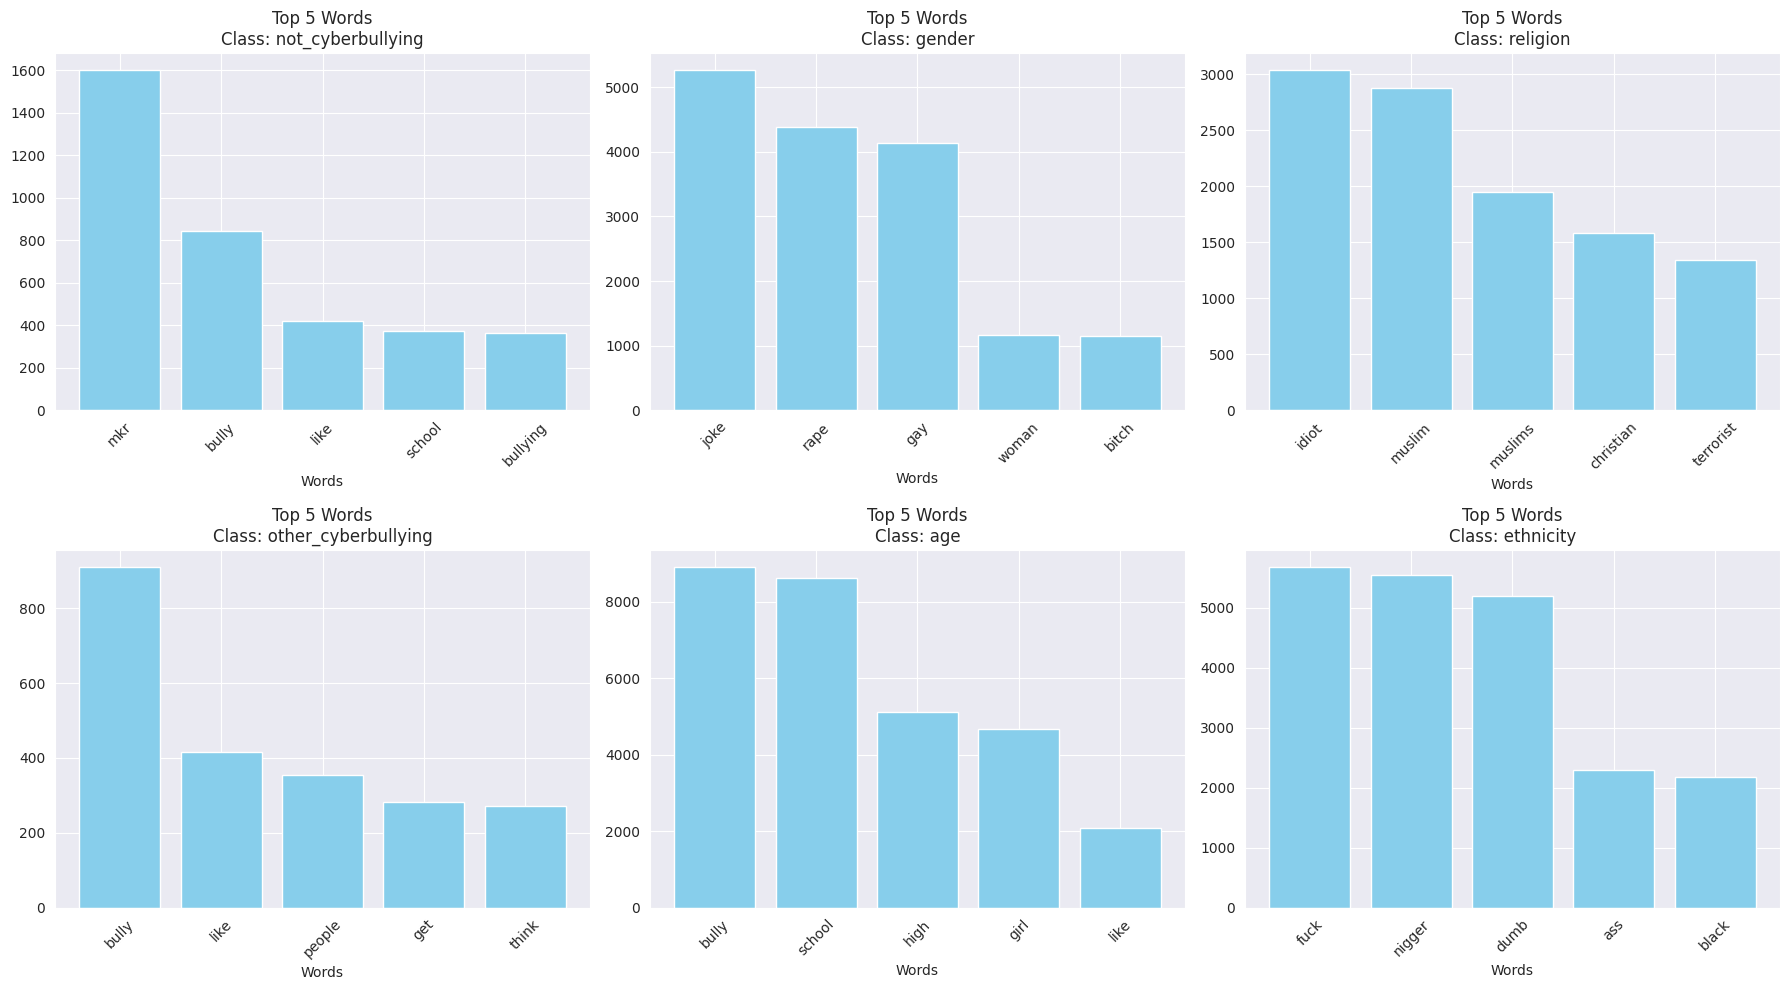

In [24]:
from collections import Counter
import math

def plot_top_words_per_class_grid(df, lemma_col='lemmas', label_col='label', top_n=5):
    labels = df[label_col].unique()
    n_labels = len(labels)

    n_rows = 2
    n_cols = math.ceil(n_labels / n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), sharey=False)
    axes = axes.flatten()  # make it a flat list for easy iteration

    for i, label in enumerate(labels):
        ax = axes[i]
        tokens = [token for tokens in df[df[label_col] == label][lemma_col] for token in tokens]
        freq_dist = Counter(tokens).most_common(top_n)

        if freq_dist:
            words, counts = zip(*freq_dist)
            ax.bar(words, counts, color='skyblue')
            ax.set_title(f"Top {top_n} Words\nClass: {label}")
            ax.set_xlabel("Words")
            ax.set_xticklabels(words, rotation=45)
        else:
            ax.set_title(f"Class: {label}\n(no data)")
            ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_top_words_per_class_grid(df, lemma_col='lemmas', label_col='cyberbullying_type', top_n=5)

We will also inspect bigrams:

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
X_bigrams = bigram_vectorizer.fit_transform(df['clean_text'])

In [26]:
import numpy as np

# Sum over all rows to get total counts
bigram_counts = np.asarray(X_bigrams.sum(axis=0)).flatten()
bigrams = bigram_vectorizer.get_feature_names_out()

In [27]:
# Create frequency dictionary
counts = X_bigrams.sum(axis=0).A1  # Convert sparse matrix to flat array
bigram_freq = dict(zip(bigrams, counts))

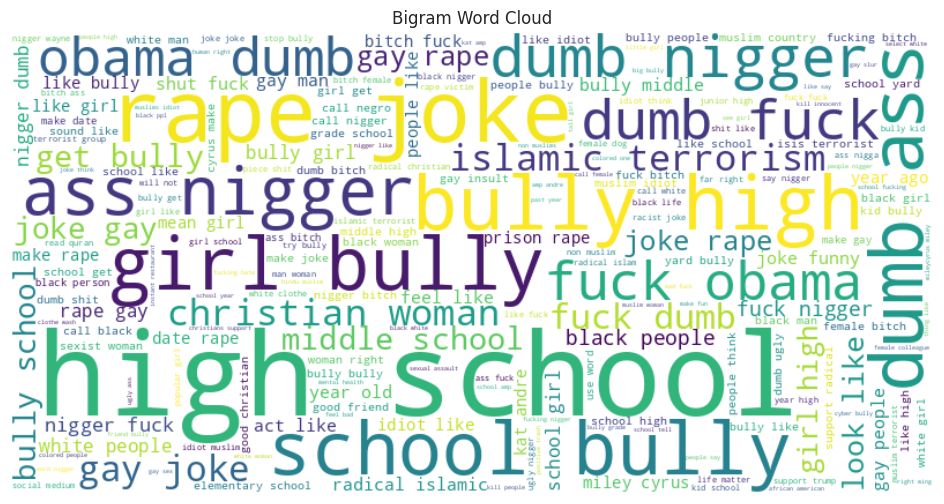

In [28]:
# Create and plot word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Bigram Word Cloud')
plt.show()

## Train Test Split

In [29]:
X = df['lemmas']
y = df['cyberbullying_type']

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify = df['cyberbullying_type'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify = df_temp['cyberbullying_type'])

X_train = df_train['lemmas']
X_val = df_val['lemmas']
X_test = df_test['lemmas']

y_train = df_train['cyberbullying_type']
y_val = df_val['cyberbullying_type']
y_test = df_test['cyberbullying_type']

In [30]:
print("Train size:", len(X_train))
print("Val   size:", len(X_val))
print("Test  size:", len(X_test))

Train size: 32211
Val   size: 6903
Test  size: 6903


## Label Encoding

In [31]:
label_encoder = LabelEncoder()
y_train_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.fit_transform(y_val)
y_test_int = label_encoder.fit_transform(y_test)

We can check if the labels are encoded as necessary:

In [32]:
# Dictionary of mappings
mapping = {cls: idx for idx, cls in enumerate(label_encoder.classes_)}

# make it into a dataframe
df_mapping = pd.DataFrame(
    mapping.items(),
    columns=["Class Name", "Encoded Label"]
)

# display
df_mapping

Class Name  Encoded Label
0                  age              0
1            ethnicity              1
2               gender              2
3    not_cyberbullying              3
4  other_cyberbullying              4
5             religion              5

## PPMI

In [33]:
docs = X_train
labels = y_train

# Step 1: Limit vocabulary to top N words
top_n = 3000
flat_words = [w for doc in docs for w in doc]
word_freq = Counter(flat_words)
top_words = set(w for w, _ in word_freq.most_common(top_n))
filtered_docs = [[w for w in doc if w in top_words] for doc in docs]

# Step 2: Create vocab and sparse co-occurrence matrix
vocab = sorted(top_words)
word2id = {w: i for i, w in enumerate(vocab)}
N = len(vocab)
window_size = 2
cooc = lil_matrix((N, N), dtype=np.float32)

for doc in filtered_docs:
    for i in range(len(doc)):
        target = doc[i]
        if target not in word2id:
            continue
        for j in range(max(0, i - window_size), min(len(doc), i + window_size + 1)):
            if i != j:
                context = doc[j]
                if context in word2id:
                    cooc[word2id[target], word2id[context]] += 1

# Step 3: Compute sparse PPMI matrix
def compute_sparse_ppmi_matrix(cooc):
    total_count = cooc.sum()
    row_totals = np.array(cooc.sum(axis=1)).flatten()
    col_totals = np.array(cooc.sum(axis=0)).flatten()

    ppmi = lil_matrix(cooc.shape)
    cooc = cooc.tocoo()

    for i, j, count in zip(cooc.row, cooc.col, cooc.data):
        p_ij = count / total_count
        p_i = row_totals[i] / total_count
        p_j = col_totals[j] / total_count
        pmi = np.log2(p_ij / (p_i * p_j))
        if pmi > 0:
            ppmi[i, j] = pmi

    return ppmi.tocsr()

ppmi_sparse = compute_sparse_ppmi_matrix(cooc)


In [34]:
# Step 4: Define RAM-safe document vectorizer

def doc_vector_sparse_safe(doc, word2id, ppmi_sparse_matrix):
    vecs = []
    for w in doc:
        if w in word2id:
            row = ppmi_sparse_matrix.getrow(word2id[w])
            vecs.append(row)
    if vecs:
        stacked = vstack(vecs)
        mean_vec = stacked.mean(axis=0)  # shape (1, N)
        return csr_matrix(mean_vec)  # makes it a 2D sparse matrix
    else:
        return csr_matrix((1, ppmi_sparse_matrix.shape[1]))  # all zeros, but valid shape

# Step 5: Build sparse feature matrix
X_list = []
y_list = []

for i, doc in enumerate(filtered_docs):
    vec = doc_vector_sparse_safe(doc, word2id, ppmi_sparse)
    X_list.append(vec)
    y_list.append(df.iloc[i]['cyberbullying_type'])


X_ppmi = vstack(X_list)
y_ppmi = np.array(y_list)

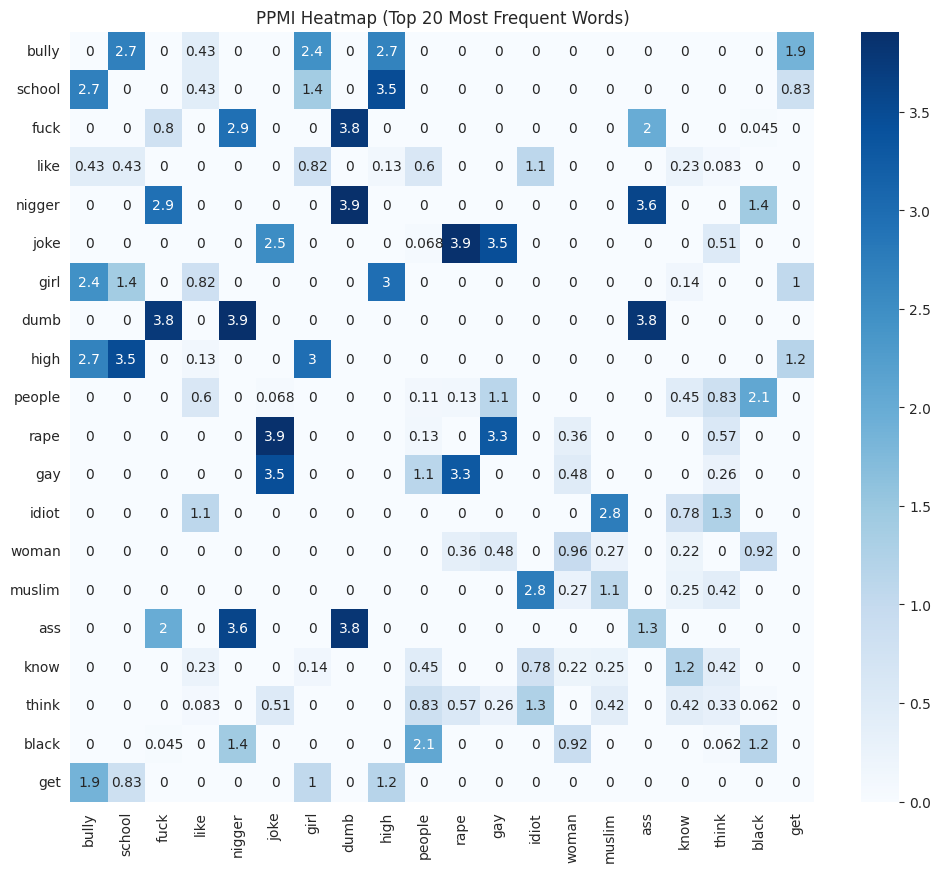

In [35]:
# Get top 20 most frequent words from word_freq
top20_words = [w for w, _ in word_freq.most_common(20) if w in word2id]
top20_ids = [word2id[w] for w in top20_words]

# Extract submatrix from sparse PPMI
sample_ppmi = ppmi_sparse[top20_ids, :][:, top20_ids].toarray()

# Create DataFrame for heatmap
sample_df = pd.DataFrame(sample_ppmi, index=top20_words, columns=top20_words)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sample_df, cmap="Blues", annot=True)
plt.title("PPMI Heatmap (Top 20 Most Frequent Words)")
plt.show()

We can use TSNE to visualize the PPMI better.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.401398
[t-SNE] KL divergence after 1000 iterations: 1.096833


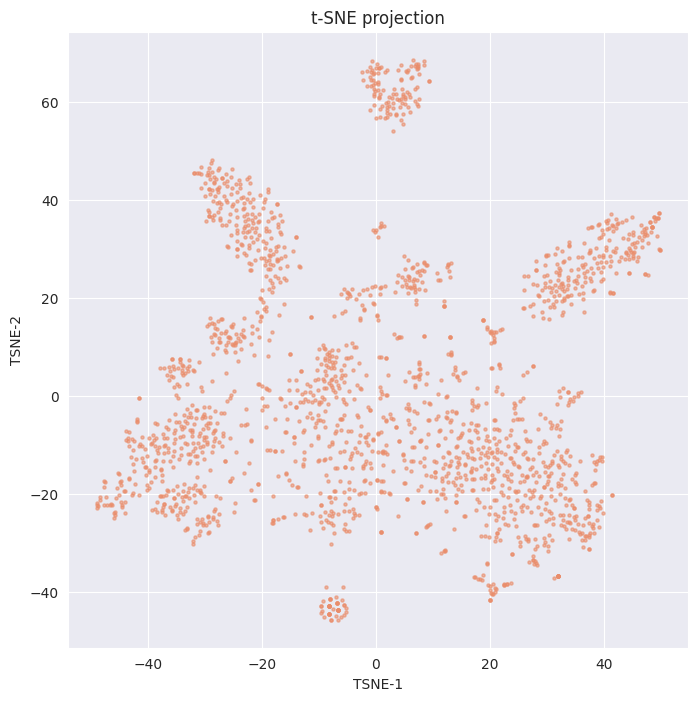

In [36]:
X = X_ppmi.toarray()   # shape: (n_docs, n_features)
X_subset = X[np.random.choice(X.shape[0], size=2000, replace=False)]

# 1) PCA projection to 50 dims
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_subset)

# 2) t-SNE to 2 dims
tsne = TSNE(
    n_components=2,
    perplexity=30,        # try between 5 and 50
    learning_rate=200,    # often between 100 and 1000
    n_iter=1000,
    init="pca",           # better than random
    random_state=42,
    verbose=1             # shows progress
)

X_tsne = tsne.fit_transform(X_pca)

# 3) Plot it
plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
            s=5, alpha=0.6)
plt.title("t-SNE projection")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()

## TF-IDF Vectorization

Firstly we train our own vocabulary using the training data:

In [37]:
tfidf_pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
                    lowercase = False, preprocessor = lambda x: x,
                    tokenizer = lambda x: x, min_df = 12)),
        ("classifier", LogisticRegression(random_state = 42, multi_class='multinomial'))
])

In [38]:
tfidf_pipeline.fit(X_train, y_train_int)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, min_df=12,
                                 preprocessor=<function <lambda> at 0x7f117c6868e0>,
                                 tokenizer=<function <lambda> at 0x7f117c686ca0>)),
                ('classifier',
                 LogisticRegression(multi_class='multinomial',
                                    random_state=42))])

We can review the trained vocabulary:

In [39]:
print(tfidf_pipeline['tfidf'].get_feature_names_out()[:20])

['abandon' 'ability' 'able' 'abortion' 'absolute' 'absolutely' 'abt'
 'abuse' 'abuser' 'abusive' 'academy' 'acc' 'accent' 'accept' 'acceptable'
 'access' 'accident' 'accord' 'account' 'accountable']


It is visible that most of the vocabulary consists of real words, and some abbreviations such as "acc".

Now we will create a heatmap obtained by the tf-idf method to compare it with the ppmi:

In [40]:
# Get vectorizer and transform X_train
tfidf = tfidf_pipeline.named_steps['tfidf']
X_tfidf_train = tfidf.transform(X_train)

# Get feature names
feature_names = tfidf.get_feature_names_out()

In [41]:
# Mean TF-IDF value per feature across training docs
mean_tfidf = np.asarray(X_tfidf_train.mean(axis=0)).flatten()
top20_idx = mean_tfidf.argsort()[::-1][:20]
top20_words = feature_names[top20_idx]

In [42]:
# Extract TF-IDF matrix for top 20 words
top20_matrix = X_tfidf_train[:, top20_idx].toarray()

tfidf_df_train = pd.DataFrame(top20_matrix, columns=top20_words)

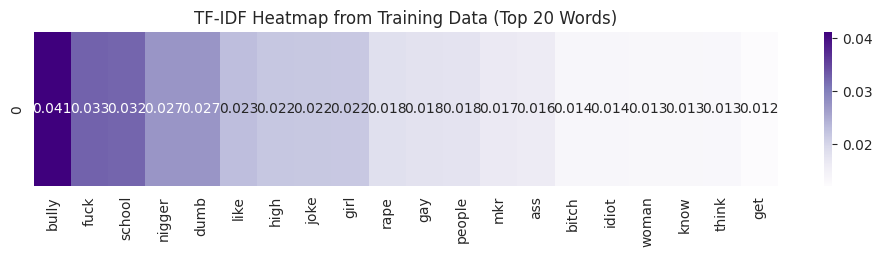

In [43]:
# Average across training docs
avg_tfidf_train = tfidf_df_train.mean(axis=0).to_frame().T

plt.figure(figsize=(12, 2))
sns.heatmap(avg_tfidf_train, cmap="Purples", annot=True)
plt.title("TF-IDF Heatmap from Training Data (Top 20 Words)")
plt.show()

## Modeling

### PPMI vs TF-IDF Representations

Now that we have both PPMI and TF-IDF representations, we will build base models using both and compare them.

In [44]:
ppmi_pipeline = Pipeline([
    ("classifier", LogisticRegression(
        random_state=42,
        multi_class='multinomial',
        max_iter=100))
])

In [45]:
X_ppmi_train = vstack([doc_vector_sparse_safe(doc, word2id, ppmi_sparse) for doc in df_train['lemmas']])
X_ppmi_val   = vstack([doc_vector_sparse_safe(doc, word2id, ppmi_sparse) for doc in df_val['lemmas']])
X_ppmi_test  = vstack([doc_vector_sparse_safe(doc, word2id, ppmi_sparse) for doc in df_test['lemmas']])

In [46]:
ppmi_pipeline.fit(X_ppmi_train, y_train_int)
y_pred_ppmi = ppmi_pipeline.predict(X_ppmi_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
print(classification_report(y_test_int, y_pred_ppmi, target_names=label_encoder.classes_))

                     precision    recall  f1-score   support

                age       0.89      0.93      0.91      1199
          ethnicity       0.92      0.94      0.93      1193
             gender       0.85      0.84      0.84      1184
  not_cyberbullying       0.57      0.52      0.55      1190
other_cyberbullying       0.53      0.56      0.54       937
           religion       0.93      0.94      0.94      1200

           accuracy                           0.80      6903
          macro avg       0.78      0.79      0.78      6903
       weighted avg       0.79      0.80      0.79      6903



In [48]:
# TF-IDF model within the pipeline
y_pred_tfidf = tfidf_pipeline.predict(X_test)

We will add a side by side comparison of how the TF-IDF and PPMI representations perform with logistic regression.

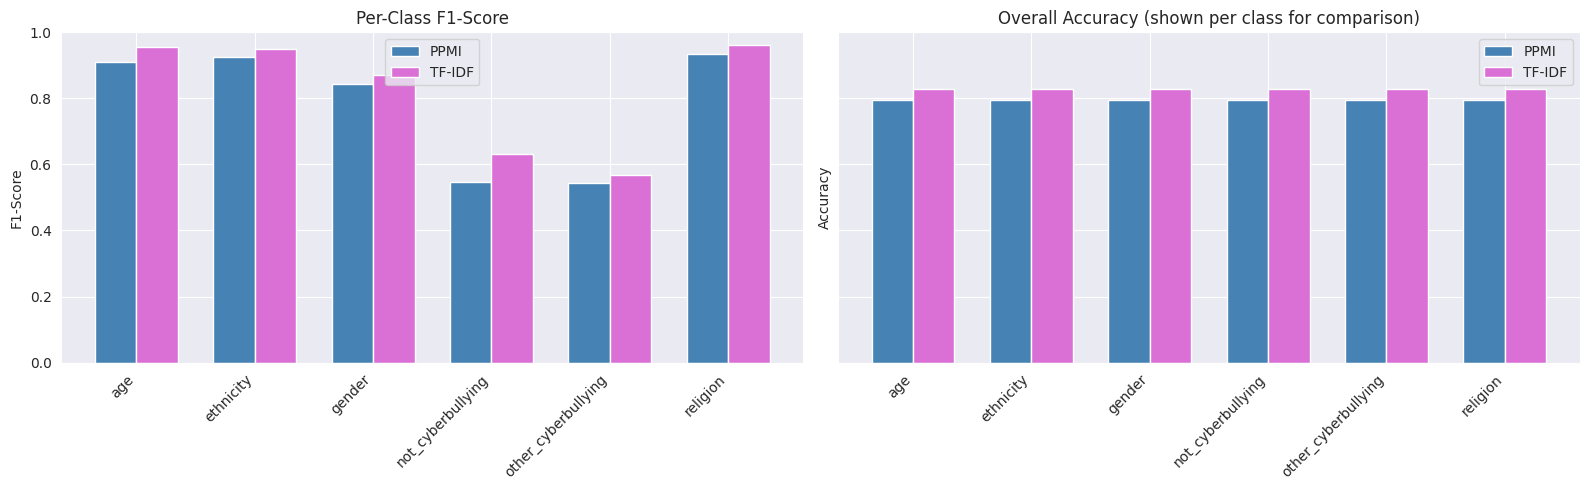

In [49]:
# Step 1: Get classification reports
report_ppmi = classification_report(y_test_int, y_pred_ppmi, output_dict=True)
report_tfidf = classification_report(y_test_int, y_pred_tfidf, output_dict=True)


# Get labels and F1-scores for plotting
# Get all keys that are digits (representing the class labels)
report_ppmi_labels = [label for label in report_ppmi.keys() if label.isdigit()]
report_tfidf_labels = [label for label in report_tfidf.keys() if label.isdigit()]

# Use the intersection of labels to ensure both reports have the key
common_labels = sorted(list(set(report_ppmi_labels) & set(report_tfidf_labels)))

# Convert numerical string labels back to original class names for plotting
labels = label_encoder.inverse_transform([int(label) for label in common_labels])


f1_ppmi = [report_ppmi[label]['f1-score'] for label in common_labels]
f1_tfidf = [report_tfidf[label]['f1-score'] for label in common_labels]

# Get overall accuracy
acc_ppmi = report_ppmi['accuracy']
acc_tfidf = report_tfidf['accuracy']

x = np.arange(len(labels))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# F1-Score Bar Chart
axes[0].bar(x - width/2, f1_ppmi, width, label='PPMI', color='steelblue')
axes[0].bar(x + width/2, f1_tfidf, width, label='TF-IDF', color='orchid')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=45, ha='right')
axes[0].set_ylabel('F1-Score')
axes[0].set_ylim(0, 1)
axes[0].set_title("Per-Class F1-Score")
axes[0].legend()

# Accuracy Score Bar Chart (display overall accuracy as a single bar or repeated for comparison)
# We will repeat it for each class for easier comparison with per-class F1 scores
axes[1].bar(x - width/2, [acc_ppmi] * len(labels), width, label='PPMI', color='steelblue')
axes[1].bar(x + width/2, [acc_tfidf] * len(labels), width, label='TF-IDF', color='orchid')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=45, ha='right')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1)
axes[1].set_title("Overall Accuracy (shown per class for comparison)")
axes[1].legend()

plt.tight_layout()
plt.show()

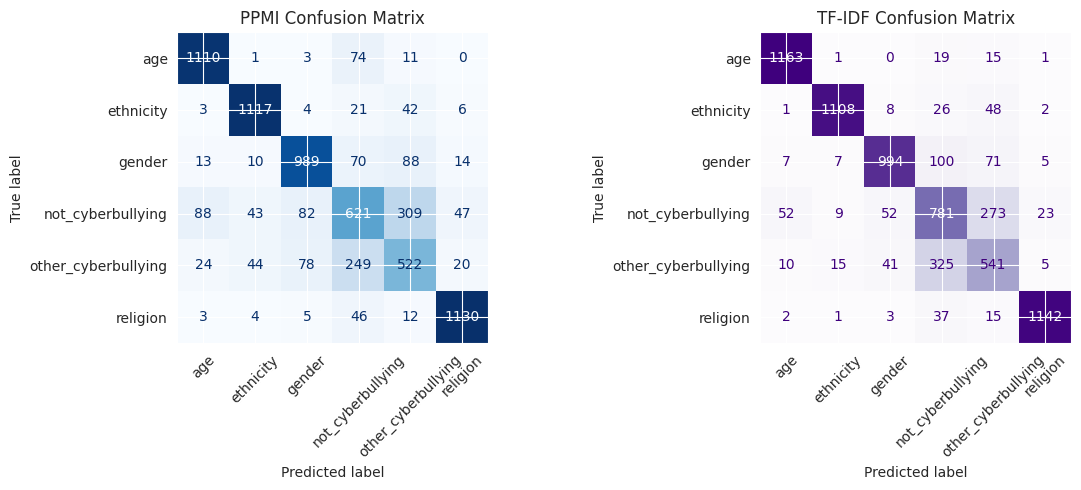

In [50]:
# Compute confusion matrices
cm_ppmi = confusion_matrix(y_test_int, y_pred_ppmi)
cm_tfidf = confusion_matrix(y_test_int, y_pred_tfidf)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PPMI confusion matrix
disp_ppmi = ConfusionMatrixDisplay(confusion_matrix=cm_ppmi, display_labels=label_encoder.classes_)
disp_ppmi.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].set_title("PPMI Confusion Matrix")

# Plot TF-IDF confusion matrix
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=label_encoder.classes_)
disp_tfidf.plot(ax=axes[1], cmap='Purples', colorbar=False)
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].set_title("TF-IDF Confusion Matrix")

plt.tight_layout()
plt.show()

We can also check some example sentences and how they are classified.

In [51]:
# 1. Build a DataFrame from scratch
df_results = pd.DataFrame({
    "tweet_text":    df_test['tweet_text'],
    "tweet_lemmas":  X_test,
    "actual_int":    y_test_int,
    "pred_int":      y_pred_tfidf
})

# 2. Decode your integer labels back to the original names
df_results["actual_class"]    = label_encoder.inverse_transform(df_results["actual_int"])
df_results["predicted_class"] = label_encoder.inverse_transform(df_results["pred_int"])


In [52]:
examples = df_results[["tweet_text","tweet_lemmas", "actual_class","predicted_class"]] \
              .sample(5, random_state=42)

display(examples)

tweet_text  \
45483  lmaooooooo fuck u nigger ... u hoopin tho RT @...   
41742  Racism is when u select ur white close to be w...   
28198  @TheRealDrMcCoy @KosmoATD @lilithsaintcrow it ...   
35019  What’s crazy is the amount of girls you made f...   
9853   Is it tv editing .. or is Kat a natural nasty ...   

                                            tweet_lemmas         actual_class  \
45483  [lmaooooooo, fuck, nigger, hoopin, tho, dumb, ...            ethnicity   
41742  [racism, select, white, close, wash, colored, ...            ethnicity   
28198                 [bug, lot, realize, read, article]  other_cyberbullying   
35019  [crazy, girl, fun, bully, high, school, time, ...                  age   
9853          [editing, kat, natural, nasty, bitch, mkr]               gender   

         predicted_class  
45483          ethnicity  
41742          ethnicity  
28198  not_cyberbullying  
35019                age  
9853              gender

### TF-IDF Representation Randomized Search

We can see that TF-IDF representation works better on average. We now perform a randomized search to find the best model configuration using this representation.

In [53]:
param_grid = [
    {
      "classifier": [LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)],
      "classifier__C": [0.1, 1]
    },
    {
      "classifier": [RandomForestClassifier(random_state=42)],
      "classifier__n_estimators": [300],
      "classifier__max_depth": [None, 20]
    },
    {
      "classifier": [MultinomialNB()],
      "classifier__alpha": [0.1, 1.0]
    },
    {
        "classifier": [XGBoost()],
        "classifier__n_estimators": [50]
    }
]

rs = RandomizedSearchCV(
    tfidf_pipeline, param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=2
)

rs.fit(X_train, y_train_int)
print("Best:", rs.best_params_, rs.best_score_)

# 6 minutes

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib

[CV] END classifier=LogisticRegression(multi_class='multinomial', random_state=42), classifier__C=0.1; total time=   1.2s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=300; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best: {'classifier__n_estimators': 300, 'classifier__max_depth': None, 'classifier': RandomForestClassifier(n_estimators=300, random_state=42)} 0.822263130105616


In [54]:
best_pipeline = rs.best_estimator_

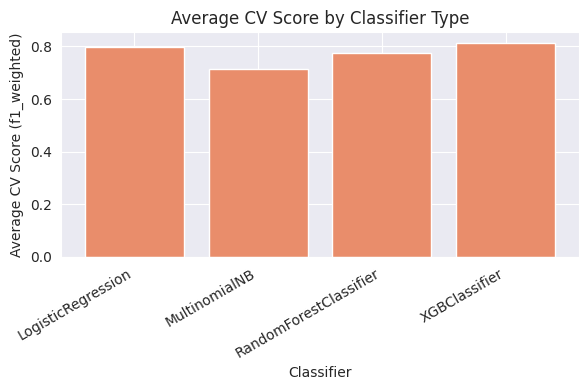

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Pull the CV results into a DataFrame
results = pd.DataFrame(rs.cv_results_)

# 3) Average CV score by classifier type
results['classifier_name'] = results['param_classifier'].apply(lambda est: est.__class__.__name__)
avg_scores = results.groupby('classifier_name')['mean_test_score'].mean().reset_index()

plt.figure(figsize=(6, 4))
plt.bar(
    avg_scores['classifier_name'],
    avg_scores['mean_test_score']
)
plt.xlabel('Classifier')
plt.ylabel('Average CV Score (f1_weighted)')
plt.title('Average CV Score by Classifier Type')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


We observe that the XGBClassifier is the best model. We will proceed with this model for hyper parameter tuning.

### Hyper Parameter Tuning

In [56]:
hp_grid = {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__max_depth": [3, 5, 10],
        "classifier__learning_rate": [0.1, 0.01],
        "classifier__lambda": [0.1, 1, 10]
        }

In [57]:
tfidf = TfidfVectorizer(
    lowercase=False,
    preprocessor=lambda x: x,
    tokenizer=lambda x: x,
    min_df=2
)
X_train_tfidf = tfidf.fit_transform(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [58]:
hp_rs = RandomizedSearchCV(
    XGBoost(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_distributions=hp_grid,
    cv=2,                  # faster for now
    n_iter=5,              # fewer combinations first
    verbose=2,             # progress logging!
    n_jobs=1,
)

In [59]:
hp_rs.fit(X_train_tfidf, y_train_int)
print("Best parameters:", hp_rs.best_params_, hp_rs.best_score_)

# 7 minutes

Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:47:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200; total time=  18.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:47:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200; total time=  19.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:48:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=10, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=  18.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:48:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=10, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=  19.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:48:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=0.1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100; total time=  18.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:49:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=0.1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100; total time=  19.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:49:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100; total time=  18.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:49:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100; total time=  18.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:49:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=  18.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:50:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=  18.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:50:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__lambda", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier=LogisticRegression(multi_class='multinomial', random_state=42), classifier__C=1; total time=   1.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=300; total time= 1.2min
[CV] END classifier=LogisticRegression(multi_class='multinomial', random_state=42), classifier__C=0.1; total time=   1.3s
[CV] END classifier=LogisticRegression(multi_class='multinomial', random_state=42), classifier__C=1; total time=   1.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=20, classifier__n_estimators=300; total time=   7.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=20, classifier__n_estimators=300; total time=   7.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=20, classifier__n_estimators=300; total time=   8.2s
[CV] END ..classifier=MultinomialNB(), classifier__alpha=0.1; total time=   0.4s
[CV] END ..

## Learning Curve

In [60]:
best_model = hp_rs.best_estimator_
print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              classifier__lambda=1, classifier__learning_rate=0.01,
              classifier__max_depth=5, classifier__n_estimators=200,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, ...)


In [61]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=XGBoost(
        max_depth=5,
        learning_rate=0.1,
        reg_lambda=0.1,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    X=X_train_tfidf,
    y=y_train_int,
    train_sizes=[50, 100, 150, 200, 250],
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

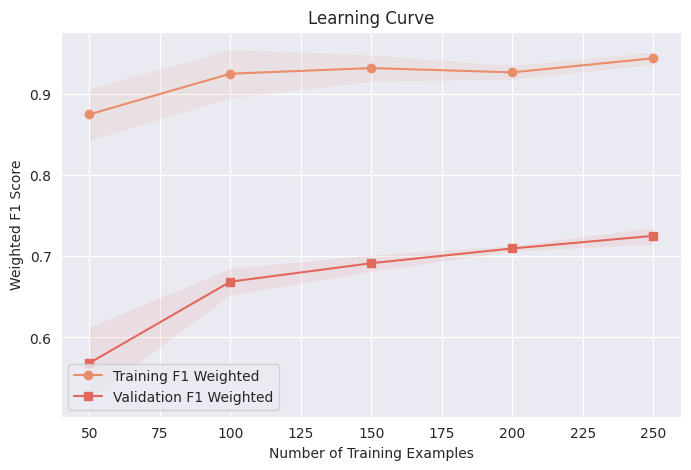

In [62]:
# Aggregate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training F1 Weighted')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 's-', label='Validation F1 Weighted')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Number of Training Examples')
plt.ylabel('Weighted F1 Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Validation Curve

In [63]:
clf = XGBoost(
        max_depth=5,
        learning_rate=0.1,
        reg_lambda=0.1,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

In [64]:
alpha_range = [1, 10, 100]
train_scores, val_scores = validation_curve(
    estimator = clf,
        X=X_train_tfidf,
        y=y_train_int,
        param_range=alpha_range,
        param_name='alpha',
        cv=3,
        n_jobs=-1,
        scoring='f1_weighted'
)

# 6 minutes

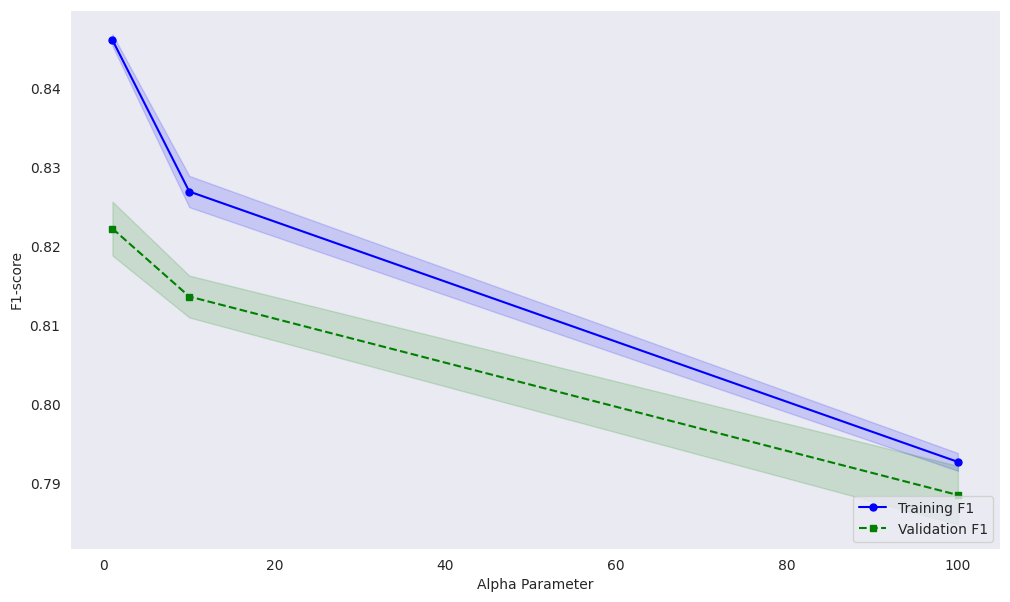

In [65]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(alpha_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training F1')

ax.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(alpha_range, val_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation F1')

ax.fill_between(alpha_range,
                 val_mean + val_std,
                 val_mean - val_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Alpha Parameter')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')

In [66]:
depth_range = [1, 3, 5]
train_scores, val_scores = validation_curve(estimator = clf,
        X=X_train_tfidf,
        y=y_train_int,
        param_range=depth_range,
        param_name='max_depth',
        cv=3,
        n_jobs=-1,
        scoring='f1_weighted'
)

# 3 minutes

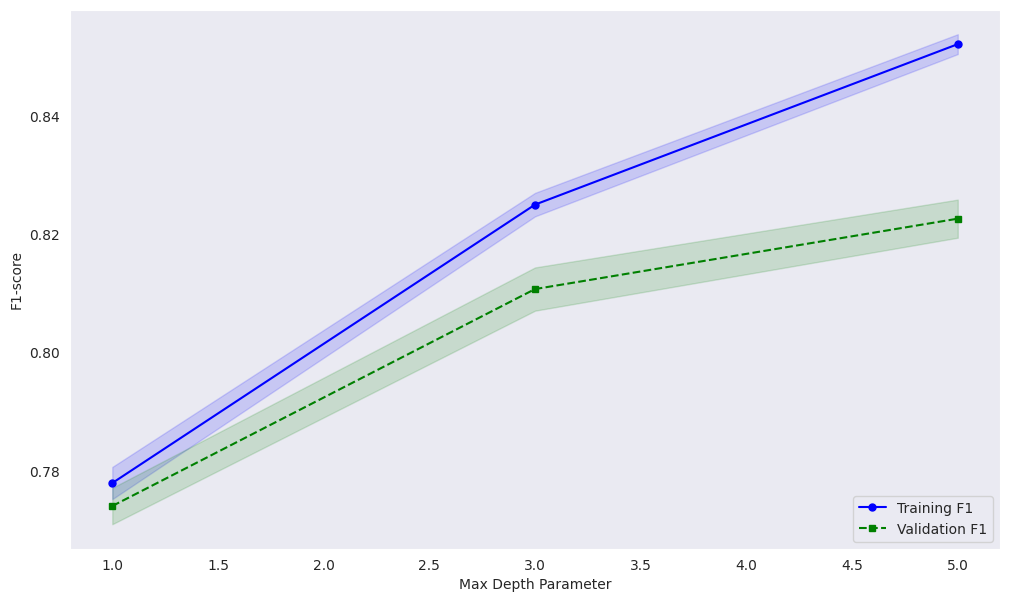

In [67]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(depth_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training F1')

ax.fill_between(depth_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(depth_range, val_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation F1')

ax.fill_between(depth_range,
                 val_mean + val_std,
                 val_mean - val_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Max Depth Parameter')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
plt.show()

In the end, the best model using the TF-IDF representation and the XGB classifier is found.

In [68]:
final = XGBoost(
        max_depth=3,
        learning_rate=0.1,
        reg_alpha=100,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

In [69]:
final.fit(X_train_tfidf, y_train_int)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [70]:
y_pred_final = final.predict(tfidf.transform(X_test))

In [71]:
report_final = classification_report(y_test_int, y_pred_final, target_names=label_encoder.classes_)
print(report_final)


                     precision    recall  f1-score   support

                age       0.98      0.97      0.98      1199
          ethnicity       0.98      0.89      0.93      1193
             gender       0.93      0.77      0.84      1184
  not_cyberbullying       0.47      0.85      0.61      1190
other_cyberbullying       0.59      0.24      0.35       937
           religion       0.96      0.90      0.93      1200

           accuracy                           0.79      6903
          macro avg       0.82      0.77      0.77      6903
       weighted avg       0.83      0.79      0.79      6903



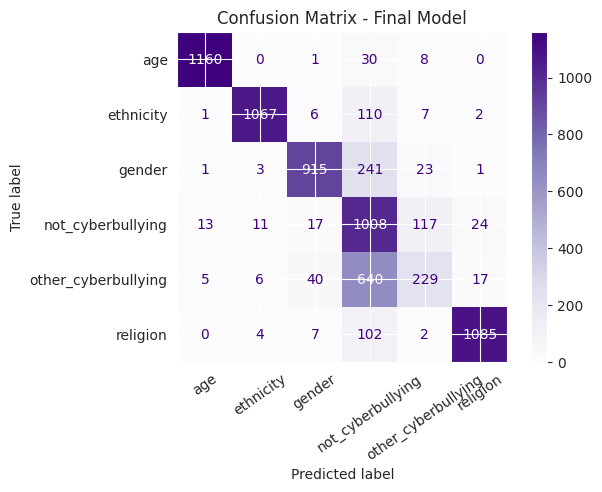

In [72]:
cm_final = confusion_matrix(y_test_int, y_pred_final)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=label_encoder.classes_)
ax = disp_final.plot(cmap="Purples").ax_
ax.tick_params(axis='x', labelrotation=35)
plt.tight_layout()
plt.title("Confusion Matrix - Final Model")
plt.show()

In [73]:
# Step 1: Predict with your final model
y_pred_final = final.predict(tfidf.transform(X_test))

# Step 2: Create a comparison DataFrame
results_df = pd.DataFrame({
    'tweet_text': df_test['tweet_text'].reset_index(drop=True),
    'lemmas': df_test['lemmas'].reset_index(drop=True),
    'true_label': label_encoder.inverse_transform(y_test_int),
    'predicted_label': label_encoder.inverse_transform(y_pred_final)
})

# Step 3: Filter misclassified rows
misclassified = results_df[results_df['true_label'] != results_df['predicted_label']]

# Step 4: Take a random sample
sample = misclassified.sample(n=20, random_state=42)

# Show it
sample


tweet_text  \
848                   @girlziplocked @Jason hahaha yams   
2948                        Is it a pony?! Oh fuck off.   
2689  @JabberwockySR i need a ticket #, the tweet in...   
336   @cage_rusty @VickyChandler now isn't this a pr...   
3075                                 @gkrnours bastards   
4066  @PeerWorker @DerAmazingLarry @Quinnae_Moon @fe...   
6687  @LeoKikiLady89 Oh, I dont.  Even the ERA only ...   
6829  Just started a new season wizard. Randi#1266 i...   
5731  @trishesdishes Are you aware women have more, ...   
1194  If your ever bullied listen to #NeverSayNever ...   
2868  i was referring to u saying josie words doesn’...   
606            What is a press kit? How do I build one?   
5856  @StutteringGiant Wasn't directed at you ugly n...   
4498                   @Trigger_Check will take a look.   
724   Cyber Bulling is a bitch, it doesn't happen to...   
4941  @ashleylynch @TimofLegend It's the first time ...   
3376  FUCK. THIS IS SO AWESOME I CAN'T STOP TYPING I...   
3634  @DickTalens @edzitron i've had decent press co...   
1470  @dylanw I don't know him. I don't know if he a...   
1731  #ArnabExposesSonia #Secular_Terrorists_Killed_...   

                                                 lemmas           true_label  \
848                                      [hahaha, yams]  other_cyberbullying   
2948                                       [pony, fuck]    not_cyberbullying   
2689    [need, ticket, tweet, question, escalate, time]  other_cyberbullying   
336        [pretty, turn, event, troll, blameonenotall]  other_cyberbullying   
3075                                          [bastard]  other_cyberbullying   
4066                             [fond, lie, say, isis]               gender   
6687  [not, era, say, right, equal, responsibility, ...               gender   
6829           [start, new, season, wizard, want, join]  other_cyberbullying   
5731             [aware, woman, few, legal, right, man]               gender   
1194  [bully, listen, neversaynever, inspirational, ...    not_cyberbullying   
2868  [refer, say, josie, word, sit, right, add, gue...            ethnicity   
606                                 [press, kit, build]  other_cyberbullying   
5856                              [direct, ugly, nigga]            ethnicity   
4498                                             [look]  other_cyberbullying   
724   [cyber, bulling, bitch, happen, notice, happen...  other_cyberbullying   
4941   [time, december, start, monitor, complain, male]  other_cyberbullying   
3376                  [fuck, awesome, stop, type, caps]    not_cyberbullying   
3634  [decent, press, coverage, far, need, org, pers...  other_cyberbullying   
1470  [know, know, act, way, base, opinion, single, ...  other_cyberbullying   
1731  [arnabexposessonia, isupportarnabgoswami, isup...             religion   

          predicted_label  
848     not_cyberbullying  
2948  other_cyberbullying  
2689    not_cyberbullying  
336     not_cyberbullying  
3075    not_cyberbullying  
4066    not_cyberbullying  
6687    not_cyberbullying  
6829    not_cyberbullying  
5731    not_cyberbullying  
1194  other_cyberbullying  
2868    not_cyberbullying  
606     not_cyberbullying  
5856    not_cyberbullying  
4498    not_cyberbullying  
724                gender  
4941    not_cyberbullying  
3376  other_cyberbullying  
3634    not_cyberbullying  
1470    not_cyberbullying  
1731    not_cyberbullying

In [74]:
sample.to_excel("misclassified_sample.xlsx", index=False)

In [75]:
from google.colab import files
files.download("misclassified_sample.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Neural networks approach

Here we will do the common preprocessing for the Neural Network that is: tokenizing, padding, truncating and loading the pre-trained embeddings. In particular we want to compare two different types of tokenizations: word-level and subword-level. Former will use the pre-trained GloVe embeddings and latter will have the custom embeddings from the LSTM layer.

The neural network requires the labels to be integers so let's encode them

In [76]:
label_encodings = {"not_cyberbullying": 0, "religion" : 1, "age" : 2, "gender" : 3, "ethnicity" : 4, "other_cyberbullying" : 5 }
df['cyberbullying_type'] = df['cyberbullying_type'].map(label_encodings)

In [77]:
df.head()

tweet_text  cyberbullying_type  \
0  In other words #katandandre, your food was cra...                   0   
1  Why is #aussietv so white? #MKR #theblock #ImA...                   0   
2  @XochitlSuckkks a classy whore? Or more red ve...                   0   
3  @Jason_Gio meh. :P  thanks for the heads up, b...                   0   
4  @RudhoeEnglish This is an ISIS account pretend...                   0   

                                          clean_text  \
0             word katandandre food crapilicious mkr   
1  aussietv white mkr theblock imacelebrityau tod...   
2                    classy whore red velvet cupcake   
3        meh thank head concerned angry dude twitter   
4  isis account pretend kurdish account like isla...   

                                              lemmas  token_count  
0       [word, katandandre, food, crapilicious, mkr]            5  
1  [aussietv, white, mkr, theblock, imacelebritya...           10  
2              [classy, whore, red, velvet, cupcake]            5  
3  [meh, thank, head, concerned, angry, dude, twi...            7  
4  [isis, account, pretend, kurdish, account, lik...            8

In [78]:
print(df['cyberbullying_type'].unique())

[0 3 1 5 2 4]


For the word_level_tokenizer I will get the embeddings from Glove model

We need the function to create the tokenizer since we are creating two of them

In [79]:
def create_tokenizer(tokenizer_type, vocab_size, dataframe, special_tokens) -> Tokenizer:
  if tokenizer_type == "wordpiece":
        model = WordPiece(unk_token="[UNK]")
        trainer = WordPieceTrainer(
            vocab_size=vocab_size,
            special_tokens=special_tokens
        )
  elif tokenizer_type == "wordlevel":
        model = WordLevel(unk_token="[UNK]")
        trainer = WordLevelTrainer(
            vocab_size=vocab_size,
            special_tokens=special_tokens
        )
  else:
      raise ValueError(f"Unknown tokenizer_type: {tokenizer_type}. Must be 'wordpiece' or 'wordlevel'")

  tokenizer = Tokenizer(model)
  tokenizer.normalizer = Lowercase()
  tokenizer.pre_tokenizer = Whitespace()


  tokenizer.train_from_iterator(iterator=dataframe, trainer=trainer)
  tokenizer.save("tokenizer.json")
  return tokenizer

def tokenize_and_pad(tokenizer, text_data, truncating_len): #combine tokenizing and padding in one function
    sequences = [tokenizer.encode(text).ids for text in text_data]
    return pad_sequences(sequences, padding = 'post', maxlen = truncating_len, truncating = 'post')


Next we introduce the functions to load the GloVe embeddings and create the embedding matrix

In [80]:
ssl._create_default_https_context = ssl._create_unverified_context #wasn't working without
def load_glove(dest_dir="glove"):
    url = f"http://nlp.stanford.edu/data/glove.6B.zip"
    zip_path = os.path.join(dest_dir, "glove.6B.zip")
    glove_file = os.path.join(dest_dir, f"glove.6B.100d.txt")

    if not os.path.exists(glove_file):
        print("Downloading GloVe embeddings...")
        os.makedirs(dest_dir, exist_ok=True)
        urllib.request.urlretrieve(url, zip_path)

        print("Extracting GloVe embeddings...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dest_dir)

    return glove_file


def get_embedding_matrix(glove_file, tokenizer, vocab_size, embedding_dim):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            embeddings_index[word] = np.array(vector, dtype=np.float32)


    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, index in tokenizer.get_vocab().items():
        embedding_vector = embeddings_index.get(word.lower())
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix


In [81]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42,shuffle = True)
validation_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42,shuffle = True)

## LSTM with word level tokenizer and GloVe embeddings

In [82]:
sp_tokens = ["[PAD]","[UNK]", "[CLS]", "[SEP]", "[MASK]"] #special tokens used in tokenizer
word_level_tokenizer = create_tokenizer("wordlevel", 25000, train_df["tweet_text"], sp_tokens)
glove_file = load_glove()
vocab = word_level_tokenizer.get_vocab()
vocab_size = len(vocab) + 1 #for padding token
print(word_level_tokenizer, "Vocabulary size:", vocab_size)
embedding_dim = 100



Extracting GloVe embeddings...
Tokenizer(version="1.0", truncation=None, padding=None, added_tokens=[{"id":0, "content":"[PAD]", "single_word":False, "lstrip":False, "rstrip":False, ...}, {"id":1, "content":"[UNK]", "single_word":False, "lstrip":False, "rstrip":False, ...}, {"id":2, "content":"[CLS]", "single_word":False, "lstrip":False, "rstrip":False, ...}, {"id":3, "content":"[SEP]", "single_word":False, "lstrip":False, "rstrip":False, ...}, {"id":4, "content":"[MASK]", "single_word":False, "lstrip":False, "rstrip":False, ...}], normalizer=Lowercase(), pre_tokenizer=Whitespace(), post_processor=None, decoder=None, model=WordLevel(vocab={"[PAD]":0, "[UNK]":1, "[CLS]":2, "[SEP]":3, "[MASK]":4, ...}, unk_token="[UNK]")) Vocabulary size: 25001


In [83]:
embedding_matrix = get_embedding_matrix(glove_file, word_level_tokenizer, vocab_size, embedding_dim)
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.26607999,  0.21168   ,  0.14855   , ..., -0.16192999,
        -0.2061    ,  0.037628  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Before proceeding with tokenizing and padding it would make sense to check how long are the sequences in our data, so that we can efficiently truncate them, which will decrease the dimensions of sequences.

In [84]:
sequences = [word_level_tokenizer.encode(text).ids for text in df['tweet_text']]
print("Max length of a sequence: ",max(len(seq) for seq in sequences))

Max length of a sequence:  1115


1115 is a huge length for a sequence, so let's check if there is many sequences with length similar to that.

In [85]:
df['sec_len'] = list(map(len,sequences))
print('Average sequence length', df['sec_len'].mean())
df[df['sec_len']>100]

Average sequence length 30.23704283199687


tweet_text  cyberbullying_type  \
1317   @EurekAlertAAAS: Researchers push to import to...                   0   
3029   He embellished the afternoon with moustachioed...                   0   
4843   @andrea_gcav: @viviaanajim recuerdas como noso...                   0   
10116  Why boys crack up at rape jokes, think having ...                   3   
10894  don't make rape jokes!!! don't make gay jokes!...                   3   
14102  IT CALLS THE FUNCTION TO THE PROCESS OR IT GE…...                   3   
14624  RT @alvarossanti: WHAAAAAAT Ã°ÂÂÂÃ°ÂÂÂÃ°...                   3   
15252  Miley Cyrus shocks fans with date-rape 'joke' ...                   3   
15541  @ufcpride40: : Terry Bean, prominent gay activ...                   3   
18072  https://www-dailymail-co-uk.cdn.ampproject.org...                   1   
21155  And yet God was able to meet their needs using...                   1   
21382  ⁦@JoeBiden⁩ UR an #Idiot. How can you support ...                   1   
22242  https://www.timesnownews.com/amp/india/article...                   1   
23328  There are Christian atheists &amp; agnostics. ...                   1   
23463  RADICAL LEFTIST GROUP Threatens Christian Pray...                   1   
24307  @NICKIMINAJ: #WutKinda\r\nAt this rate the MKR...                   5   
25030  @Sweetie_Niesha: So Im getting bullied via twi...                   5   
25452  If cats looked like frogs we'd realize what na...                   5   
28076  is feminazi an actual word with a denot…\r\n@N...                   5   
28566  @Crhedrys: Pussy licking pussy.... meow meow #...                   5   
29309  I don't retreat.\r\nyessssssss http://t.co/Td9...                   5   
31182  (2/2) The MO State Constitution (Art. VI sec 1...                   2   
32058  ... I don't feel guilty for killing him, I jus...                   2   
42366  You so black and white trying to live like a n...                   4   
42625  @JasmineLovvee If He Dont Want You Well Fuck H...                   4   
43495  @hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...                   4   
45363  @Purely_Ambition: Sooo mad. RT @TracePeterson ...                   4   

                                              clean_text  \
1317   researcher push import anti bullying program s...   
3029   embellish afternoon moustachioed feints amp fl...   
4843   recuerda como nosotras también eramos victimas...   
10116  boy crack rape joke think have girlfriend gay ...   
10894  rape joke gay joke fat joke okay cause depress...   
14102  call function process punk ass low self esteem...   
14624  whaaaaaat insane gurl finilly watch bitch bles...   
15252  miley cyrus shock fan date rape joke gay londo...   
15541  terry bean prominent gay activist major obama ...   
18072  islamic terrorism knife jihad attack nypd offi...   
21155  god able meet need radical everyday generosity...   
21382  idiot support anti semitic joe biden speak mil...   
22242  incident happen june speak completely ignore r...   
23328  christian atheist amp agnostic pastor amp prie...   
23463  radical leftist group threaten christian praye...   
24307  wutkinda rate mkr final december mkr haha true...   
25030  get bully twitter read breitbart scene captain...   
25452  cat look like frog realize nasty cruel little ...   
28076  feminazi actual word denot job mean protect pe...   
28566  pussy lick pussy meow meow think password work...   
29309  retreat yessssssss grownup boruto look light b...   
31182  state constitution art sec prohibit charter co...   
32058  feel guilty kill feel guilty enjoy torment chi...   
42366  black white try live like nigger pahahahaha co...   
42625  not want fuck not worth tear sweat dumb nigger...   
43495  fuck obama dumb ass nigger bitch whore smh thi...   
45363  sooo mad fuck obama dumb nigger switzerlan yoo...   

                                                  lemmas  token_count  sec_len  
1317   [researcher, push, import, anti, bul

Text(0.5, 1.0, 'Box Plot of sequence lengths')

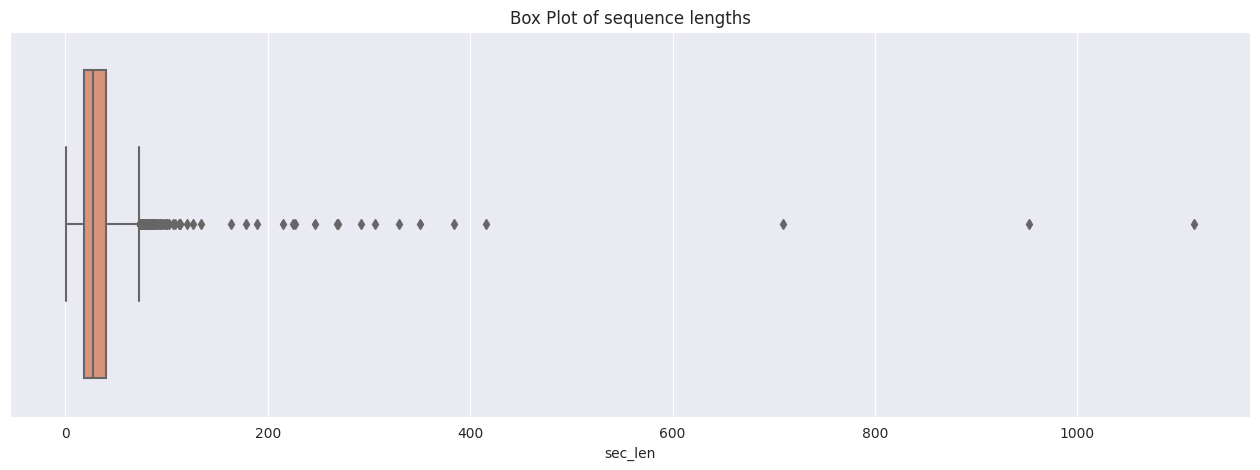

In [86]:
plt.figure(figsize = (16,5))
sns.boxplot(x = df['sec_len'])
plt.title('Box Plot of sequence lengths')

Everything above 100 can be considered outliers and we can restrict the max length of the padding this way, which will save a lot of time on training. We also do not need the new column anymore.

In [87]:
df = df.drop("sec_len",axis = 1)

Now let's pad the sequences

In [88]:
padded_train_sequences = tokenize_and_pad(word_level_tokenizer, train_df['tweet_text'], 100)
padded_validation_sequences = tokenize_and_pad(word_level_tokenizer, validation_df['tweet_text'], 100)
padded_test_sequences = tokenize_and_pad(word_level_tokenizer, test_df['tweet_text'], 100)

Now we are ready to train the models. But first let's introduce some useful functions to plot the results

In [89]:
def plot_history(history): #plots the loss and accuracy through epochs
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].plot(history.history['loss'])
  ax[0].plot(history.history['val_loss'])
  ax[0].set_title('Model Loss')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Validation'], loc='upper right')
  ax[1].plot(history.history['accuracy'])
  ax[1].plot(history.history['val_accuracy'])
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Validation'], loc='upper left')
  plt.show()

def plot_confusion_matrix_and_cl_rep(y_true, y_preds, class_names): #plots the confusion matrix and classification report of the model
    conf_matrix = confusion_matrix(y_true,y_preds)
    sns.heatmap(conf_matrix,cmap = 'Blues',annot = True, fmt = 'd',xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    print(classification_report(y_true, y_preds, target_names = class_names))

Let's create a model and perform a small grid search

In [90]:
def create_model(vocab_size, glove_embeddings, embedding_dim, embedding_matrix, units, dropout_prob, learning_rate):
  model = tf.keras.Sequential()
  if glove_embeddings == True:
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
            weights = [embedding_matrix],
            trainable = True,
            mask_zero=True))
  else:
     model.add(tf.keras.layers.Embedding(input_dim = vocab_size,
                                         output_dim = embedding_dim,
                                         mask_zero = True))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units,return_sequences = False)))
  model.add(tf.keras.layers.Dense(units, activation='relu', kernel_regularizer='l2'))
  model.add(tf.keras.layers.Dropout(dropout_prob))
  model.add(tf.keras.layers.Dense(6, activation = 'softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])
  return model

In [91]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
list_of_models = []
for units in [32,64]:
  model_word_level = create_model(vocab_size = vocab_size, glove_embeddings = True,
                                  embedding_dim = 100, embedding_matrix=embedding_matrix, units = units, dropout_prob = 0.3, learning_rate = 1e-4)
  history = model_word_level.fit(padded_train_sequences, train_df['cyberbullying_type'], epochs=20,
                                validation_data=(padded_validation_sequences, validation_df['cyberbullying_type'])
                                ,callbacks = [early_stop])
  list_of_models.append(history)

I0000 00:00:1750708737.192941      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750708737.193663      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1750708744.098378     143 cuda_dnn.cc:529] Loaded cuDNN version 90300


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.3506 - loss: 1.9685 - val_accuracy: 0.6742 - val_loss: 1.1588
Epoch 2/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6905 - loss: 1.0792 - val_accuracy: 0.7696 - val_loss: 0.8029
Epoch 3/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7666 - loss: 0.8006 - val_accuracy: 0.7901 - val_loss: 0.6843
Epoch 4/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7869 - loss: 0.6848 - val_accuracy: 0.7963 - val_loss: 0.6183
Epoch 5/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8003 - loss: 0.6065 - val_accuracy: 0.7994 - val_loss: 0.5799
Epoch 6/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8184 - loss: 0.5472 - val_accuracy: 0.8138 - val_loss: 0.5334
Epoch 7/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8287 - loss: 0.5054 - val_accuracy: 0.8165 - val_loss: 0.5108
Epoch 8/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8364 - loss: 0.47

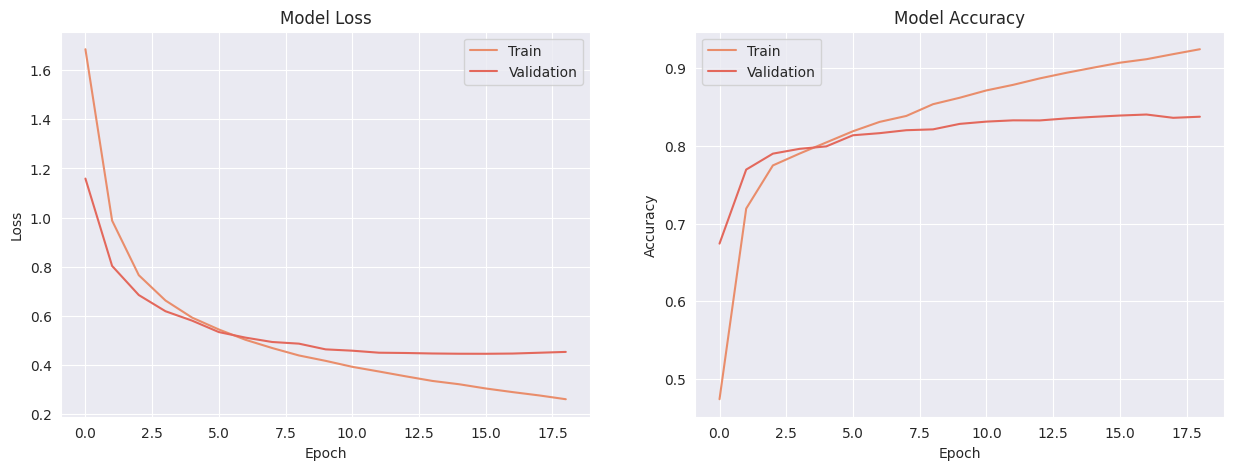

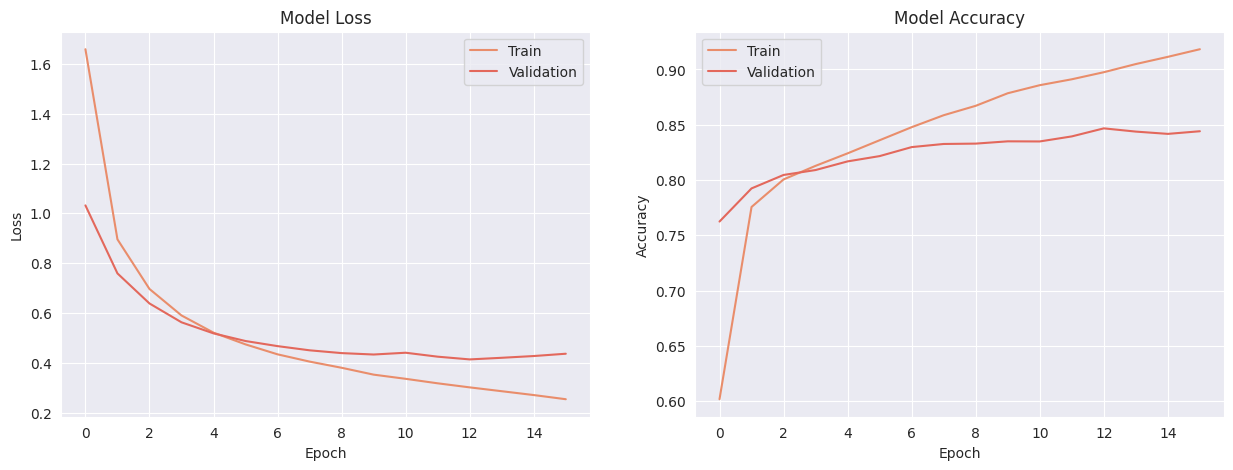

In [92]:
for history in list_of_models:
    print(history)
    plot_history(history)

In [93]:
model_word_level.save("lstm_glove_model.keras")

We can see that the model reaches it's best result almost immediately. Most probably it is impossible to reach the better result with this configuration.

In [94]:
preds = model_word_level.predict(padded_test_sequences)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [95]:
preds_classes = np.argmax(preds, axis=1)

In [96]:
accuracy = np.mean(preds_classes == test_df['cyberbullying_type'])
accuracy

0.8531073446327684

                     precision    recall  f1-score   support

  not_cyberbullying       0.67      0.65      0.66       833
           religion       0.94      0.95      0.95       807
                age       0.96      0.98      0.97       788
             gender       0.92      0.86      0.89       749
          ethnicity       0.99      0.97      0.98       804
other_cyberbullying       0.61      0.69      0.65       621

           accuracy                           0.85      4602
          macro avg       0.85      0.85      0.85      4602
       weighted avg       0.86      0.85      0.85      4602



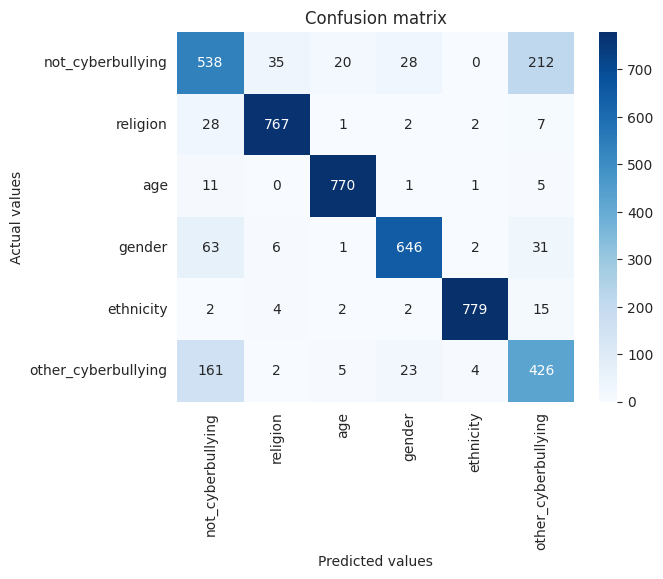

In [97]:
plot_confusion_matrix_and_cl_rep(test_df['cyberbullying_type'],preds_classes,label_encodings.keys())

From the confusion matrix we can say that the model does well with distinguishing everything apart from no cyberbullying and other cyberbullying. It may be connected to the specificity of the 'other cyberbullying' class. The classification report looks much better compared to the traditional NLP approaches

## Word piece with LSTM

In [98]:
word_piece_tokenizer = create_tokenizer('wordpiece',30000,train_df['tweet_text'], sp_tokens) #bigger vocabulary since there are many small tokens
vocab_size = len(word_piece_tokenizer.get_vocab())+1
embedding_dim = 100
padded_train_sequences = tokenize_and_pad(word_piece_tokenizer,train_df['tweet_text'],150) #bigger truncation length because subword has more tokens
padded_validation_sequences = tokenize_and_pad(word_piece_tokenizer,validation_df['tweet_text'],150)
padded_test_sequences = tokenize_and_pad(word_piece_tokenizer,test_df['tweet_text'],150)

Epoch 1/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2823 - loss: 2.0181 - val_accuracy: 0.6545 - val_loss: 1.1157
Epoch 2/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6657 - loss: 1.0739 - val_accuracy: 0.7675 - val_loss: 0.7725
Epoch 3/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7631 - loss: 0.7675 - val_accuracy: 0.7739 - val_loss: 0.6869
Epoch 4/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7879 - loss: 0.6374 - val_accuracy: 0.7895 - val_loss: 0.5854
Epoch 5/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8108 - loss: 0.5457 - val_accuracy: 0.7847 - val_loss: 0.5710
Epoch 6/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8229 - loss: 0.4960 - val_accuracy: 0.7917 - val_loss: 0.5550
Epoch 7/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8404 - loss: 0.4515 - val_accuracy: 0.7913 - val_loss: 0.5563
Epoch 8/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8609 -

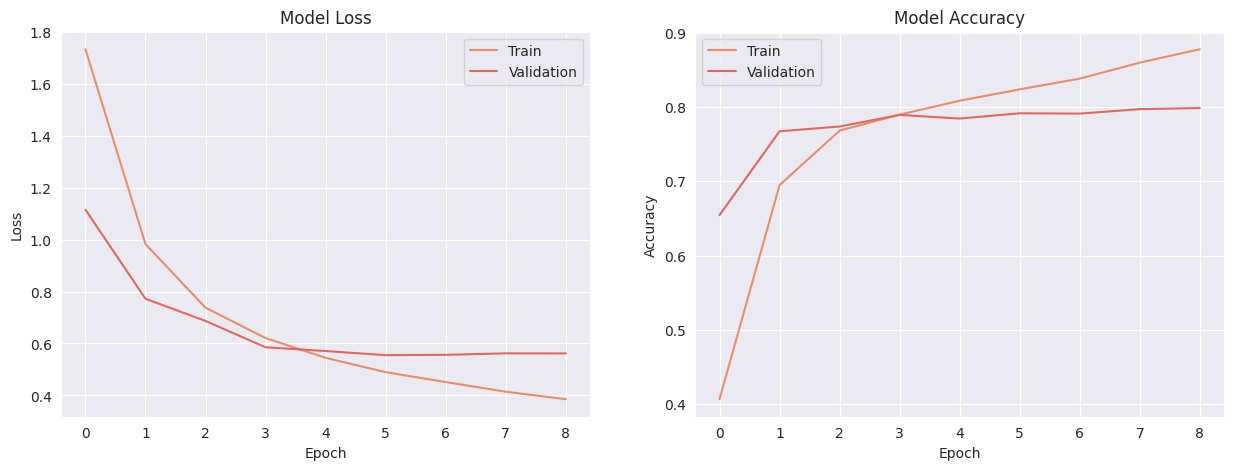

In [99]:
model_word_piece = create_model(vocab_size = vocab_size, glove_embeddings = False, embedding_dim = 100, embedding_matrix = None, units = 32, dropout_prob = 0.5, learning_rate = 1e-4)
history = model_word_piece.fit(padded_train_sequences, train_df['cyberbullying_type'], epochs=20, validation_data=(padded_validation_sequences, validation_df['cyberbullying_type']),callbacks = [early_stop])
plot_history(history)

In [100]:
model_word_piece.save('lstm_word_piece.keras')

In [101]:
preds_word_piece = model_word_piece.predict(padded_test_sequences)
preds_classes_word_piece = np.argmax(preds_word_piece, axis = 1)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


                     precision    recall  f1-score   support

  not_cyberbullying       0.50      0.72      0.59       833
           religion       0.93      0.93      0.93       807
                age       0.93      0.98      0.95       788
             gender       0.87      0.85      0.86       749
          ethnicity       0.97      0.97      0.97       804
other_cyberbullying       0.45      0.16      0.24       621

           accuracy                           0.79      4602
          macro avg       0.78      0.77      0.76      4602
       weighted avg       0.79      0.79      0.78      4602



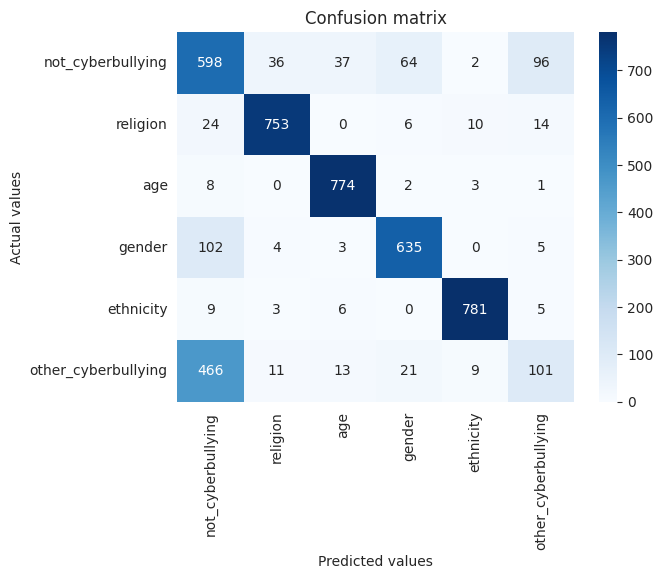

In [102]:
plot_confusion_matrix_and_cl_rep(test_df['cyberbullying_type'],preds_classes_word_piece,label_encodings.keys())

The word_piece model with custom embeddings behaves worse than the word level with GloVe embeddings. It overfits and the val_accuracy is not as big as with other approaches. It may be because the dataset is not big enough to train the custom embeddings. The classification report is also worse comparing to the previous LSTM

## Transformer architecture approach

For the transformer I will import the Distil Bert which is a distilled version of bert, and put the Sequence Classification head on it. Then i will train it for our data to be appliable for the task.

In [103]:
model_name = "distilbert-base-uncased"
id2label = {0: "not_cyberbullying", 1 : "religion", 2 : "age", 3 : "gender", 4 : "ethnicity", 5 : "other_cyberbullying" }
label2id = {"not_cyberbullying": 0, "religion" : 1, "age" : 2, "gender" : 3, "ethnicity" : 4, "other_cyberbullying" : 5 }
model = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels = 6, id2label = id2label, label2id = label2id)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["tweet_text"],max_length = 128, padding="max_length", truncation=True)
df_dataset = Dataset.from_pandas(df)
df_dataset = df_dataset.rename_column("cyberbullying_type", "labels")
df_dataset = df_dataset.cast_column("labels", datasets.features.ClassLabel(names=list(id2label.values()))) # Cast to ClassLabel
df_encoded = df_dataset.map(tokenize, batched = True, batch_size = None)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Casting the dataset:   0%|          | 0/46017 [00:00<?, ? examples/s]

Map:   0%|          | 0/46017 [00:00<?, ? examples/s]

In [104]:
df_encoded

Dataset({
    features: ['tweet_text', 'labels', 'clean_text', 'lemmas', 'token_count', 'input_ids', 'attention_mask'],
    num_rows: 46017
})

In [105]:
len(df_encoded[1]["input_ids"])

128

In [106]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [107]:
def get_accuracy(preds):
  labels = preds.label_ids
  predictions = preds.predictions.argmax(axis = -1)
  accuracy = accuracy_score(labels, predictions)
  return {"accuracy": accuracy}


split_dataset = df_encoded.train_test_split(test_size=0.3, seed=42)
train_dataset = split_dataset['train']
temp_dataset = split_dataset['test']
split_dataset_2 = temp_dataset.train_test_split(test_size = 1/3, seed = 42)
eval_dataset = split_dataset_2['train']
test_dataset = split_dataset_2['test']

train_args = TrainingArguments(output_dir = "./results" , eval_strategy = 'steps', eval_steps = 250,
                               per_device_train_batch_size = 16, per_device_eval_batch_size = 16,
                               learning_rate = 4e-5,logging_dir = "./log", logging_strategy = "steps", save_strategy = "steps",
                               num_train_epochs = 3, load_best_model_at_end = True,  metric_for_best_model='accuracy',report_to='none', logging_steps=100, fp16=True,)
trainer  = Trainer(model = model,args = train_args,  train_dataset = train_dataset, eval_dataset= eval_dataset, compute_metrics = get_accuracy, tokenizer = tokenizer)
trainer.add_callback(ProgressCallback())
trainer.train()



/tmp/ipykernel_35/1862279257.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer  = Trainer(model = model,args = train_args,  train_dataset = train_dataset, eval_dataset= eval_dataset, compute_metrics = get_accuracy, tokenizer = tokenizer)


  0%|          | 0/3021 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.8873, 'grad_norm': 241417.703125, 'learning_rate': 3.868917576961271e-05, 'epoch': 0.1}
{'loss': 0.445, 'grad_norm': 177984.96875, 'learning_rate': 3.7365110890433635e-05, 'epoch': 0.2}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.4001840054988861, 'eval_accuracy': 0.8380052151238592, 'eval_runtime': 22.5466, 'eval_samples_per_second': 408.222, 'eval_steps_per_second': 12.774, 'epoch': 0.25}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4052, 'grad_norm': 365425.84375, 'learning_rate': 3.6041046011254556e-05, 'epoch': 0.3}
{'loss': 0.4097, 'grad_norm': 277537.15625, 'learning_rate': 3.471698113207548e-05, 'epoch': 0.4}
{'loss': 0.3771, 'grad_norm': 173449.59375, 'learning_rate': 3.33929162528964e-05, 'epoch': 0.5}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.35838353633880615, 'eval_accuracy': 0.855606258148631, 'eval_runtime': 22.8077, 'eval_samples_per_second': 403.548, 'eval_steps_per_second': 12.627, 'epoch': 0.5}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3724, 'grad_norm': 165917.703125, 'learning_rate': 3.206885137371731e-05, 'epoch': 0.6}
{'loss': 0.3493, 'grad_norm': 123038.9921875, 'learning_rate': 3.0744786494538234e-05, 'epoch': 0.7}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.32873937487602234, 'eval_accuracy': 0.8673402868318123, 'eval_runtime': 23.0027, 'eval_samples_per_second': 400.128, 'eval_steps_per_second': 12.52, 'epoch': 0.74}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3566, 'grad_norm': 144378.71875, 'learning_rate': 2.9420721615359155e-05, 'epoch': 0.79}
{'loss': 0.3525, 'grad_norm': 109254.546875, 'learning_rate': 2.8096656736180076e-05, 'epoch': 0.89}
{'loss': 0.3263, 'grad_norm': 204564.5, 'learning_rate': 2.6772591857000994e-05, 'epoch': 0.99}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.314395546913147, 'eval_accuracy': 0.8711429813124728, 'eval_runtime': 23.0767, 'eval_samples_per_second': 398.844, 'eval_steps_per_second': 12.48, 'epoch': 0.99}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.272, 'grad_norm': 148247.515625, 'learning_rate': 2.5448526977821915e-05, 'epoch': 1.09}
{'loss': 0.2766, 'grad_norm': 387791.65625, 'learning_rate': 2.4124462098642837e-05, 'epoch': 1.19}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.3280843496322632, 'eval_accuracy': 0.8730986527596697, 'eval_runtime': 23.0962, 'eval_samples_per_second': 398.506, 'eval_steps_per_second': 12.47, 'epoch': 1.24}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2647, 'grad_norm': 145705.34375, 'learning_rate': 2.2800397219463758e-05, 'epoch': 1.29}
{'loss': 0.2496, 'grad_norm': 186018.65625, 'learning_rate': 2.1476332340284672e-05, 'epoch': 1.39}
{'loss': 0.2332, 'grad_norm': 138362.90625, 'learning_rate': 2.0152267461105593e-05, 'epoch': 1.49}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.30913254618644714, 'eval_accuracy': 0.8818991742720557, 'eval_runtime': 23.1705, 'eval_samples_per_second': 397.23, 'eval_steps_per_second': 12.43, 'epoch': 1.49}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2616, 'grad_norm': 219052.265625, 'learning_rate': 1.8828202581926515e-05, 'epoch': 1.59}
{'loss': 0.2634, 'grad_norm': 415349.71875, 'learning_rate': 1.7504137702747436e-05, 'epoch': 1.69}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.31590068340301514, 'eval_accuracy': 0.8763581051716645, 'eval_runtime': 23.1972, 'eval_samples_per_second': 396.773, 'eval_steps_per_second': 12.415, 'epoch': 1.74}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2592, 'grad_norm': 287535.1875, 'learning_rate': 1.6180072823568357e-05, 'epoch': 1.79}
{'loss': 0.2675, 'grad_norm': 267780.15625, 'learning_rate': 1.4856007944389277e-05, 'epoch': 1.89}
{'loss': 0.2365, 'grad_norm': 315197.625, 'learning_rate': 1.3531943065210196e-05, 'epoch': 1.99}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.3016800582408905, 'eval_accuracy': 0.882768361581921, 'eval_runtime': 23.2134, 'eval_samples_per_second': 396.496, 'eval_steps_per_second': 12.407, 'epoch': 1.99}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.193, 'grad_norm': 61704.3203125, 'learning_rate': 1.2207878186031117e-05, 'epoch': 2.09}
{'loss': 0.1553, 'grad_norm': 153389.625, 'learning_rate': 1.0883813306852035e-05, 'epoch': 2.18}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.3276389539241791, 'eval_accuracy': 0.8825510647544546, 'eval_runtime': 23.1524, 'eval_samples_per_second': 397.539, 'eval_steps_per_second': 12.439, 'epoch': 2.23}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1692, 'grad_norm': 295782.84375, 'learning_rate': 9.559748427672956e-06, 'epoch': 2.28}
{'loss': 0.1629, 'grad_norm': 191854.265625, 'learning_rate': 8.235683548493878e-06, 'epoch': 2.38}
{'loss': 0.1626, 'grad_norm': 239367.40625, 'learning_rate': 6.911618669314797e-06, 'epoch': 2.48}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.3352603018283844, 'eval_accuracy': 0.8799435028248588, 'eval_runtime': 23.1129, 'eval_samples_per_second': 398.218, 'eval_steps_per_second': 12.461, 'epoch': 2.48}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1602, 'grad_norm': 275754.5, 'learning_rate': 5.587553790135717e-06, 'epoch': 2.58}
{'loss': 0.1626, 'grad_norm': 306519.6875, 'learning_rate': 4.263488910956637e-06, 'epoch': 2.68}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.3353348672389984, 'eval_accuracy': 0.8808126901347241, 'eval_runtime': 23.8811, 'eval_samples_per_second': 385.409, 'eval_steps_per_second': 12.06, 'epoch': 2.73}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1658, 'grad_norm': 242280.328125, 'learning_rate': 2.9394240317775574e-06, 'epoch': 2.78}
{'loss': 0.1535, 'grad_norm': 220787.9375, 'learning_rate': 1.6153591525984774e-06, 'epoch': 2.88}
{'loss': 0.1565, 'grad_norm': 354659.15625, 'learning_rate': 2.9129427341939756e-07, 'epoch': 2.98}


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.3371732532978058, 'eval_accuracy': 0.8794002607561929, 'eval_runtime': 23.222, 'eval_samples_per_second': 396.349, 'eval_steps_per_second': 12.402, 'epoch': 2.98}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 1016.4782, 'train_samples_per_second': 95.066, 'train_steps_per_second': 2.972, 'train_loss': 0.2825959150225309, 'epoch': 3.0}


TrainOutput(global_step=3021, training_loss=0.2825959150225309, metrics={'train_runtime': 1016.4782, 'train_samples_per_second': 95.066, 'train_steps_per_second': 2.972, 'total_flos': 3200408816288256.0, 'train_loss': 0.2825959150225309, 'epoch': 3.0})

In [108]:
model.save_pretrained("./distilbert_finetuned/")
tokenizer.save_pretrained("./distilbert_finetuned/")

('./distilbert_finetuned/tokenizer_config.json',
 './distilbert_finetuned/special_tokens_map.json',
 './distilbert_finetuned/vocab.txt',
 './distilbert_finetuned/added_tokens.json')

In [109]:
log_df = pd.DataFrame(trainer.state.log_history)
log_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


loss      grad_norm  learning_rate     epoch  step  eval_loss  \
0   0.8873  241417.703125   3.868918e-05  0.099305   100        NaN   
1   0.4450  177984.968750   3.736511e-05  0.198610   200        NaN   
2      NaN            NaN            NaN  0.248262   250   0.400184   
3   0.4052  365425.843750   3.604105e-05  0.297915   300        NaN   
4   0.4097  277537.156250   3.471698e-05  0.397219   400        NaN   
5   0.3771  173449.593750   3.339292e-05  0.496524   500        NaN   
6      NaN            NaN            NaN  0.496524   500   0.358384   
7   0.3724  165917.703125   3.206885e-05  0.595829   600        NaN   
8   0.3493  123038.992188   3.074479e-05  0.695134   700        NaN   
9      NaN            NaN            NaN  0.744786   750   0.328739   
10  0.3566  144378.718750   2.942072e-05  0.794439   800        NaN   
11  0.3525  109254.546875   2.809666e-05  0.893744   900        NaN   
12  0.3263  204564.500000   2.677259e-05  0.993049  1000        NaN   
13     NaN            NaN            NaN  0.993049  1000   0.314396   
14  0.2720  148247.515625   2.544853e-05  1.092354  1100        NaN   
15  0.2766  387791.656250   2.412446e-05  1.191658  1200        NaN   
16     NaN            NaN            NaN  1.241311  1250   0.328084   
17  0.2647  145705.343750   2.280040e-05  1.290963  1300        NaN   
18  0.2496  186018.656250   2.147633e-05  1.390268  1400        NaN   
19  0.2332  138362.906250   2.015227e-05  1.489573  1500        NaN   
20     NaN            NaN            NaN  1.489573  1500   0.309133   
21  0.2616  219052.265625   1.882820e-05  1.588878  1600        NaN   
22  0.2634  415349.718750   1.750414e-05  1.688183  1700        NaN   
23     NaN            NaN            NaN  1.737835  1750   0.315901   
24  0.2592  287535.187500   1.618007e-05  1.787488  1800        NaN   
25  0.2675  267780.156250   1.485601e-05  1.886792  1900        NaN   
26  0.2365  315197.625000   1.353194e-05  1.986097  2000        NaN   
27     NaN            NaN            NaN  1.986097  2000   0.301680   
28  0.1930   61704.320312   1.220788e-05  2.085402  2100        NaN   
29  0.1553  153389.625000   1.088381e-05  2.184707  2200        NaN   
30     NaN            NaN            NaN  2.234359  2250   0.327639   
31  0.1692  295782.843750   9.559748e-06  2.284012  2300        NaN   
32  0.1629  191854.265625   8.235684e-06  2.383317  2400        NaN   
33  0.1626  239367.406250   6.911619e-06  2.482622  2500        NaN   
34     NaN            NaN            NaN  2.482622  2500   0.335260   
35  0.1602  275754.500000   5.587554e-06  2.581927  2600        NaN   
36  0.1626  306519.687500   4.263489e-06  2.681231  2700        NaN   
37     NaN            NaN            NaN  2.730884  2750   0.335335   
38  0.1658  242280.328125   2.939424e-06  2.780536  2800        NaN   
39  0.1535  220787.937500   1.615359e-06  2.879841  2900        NaN   
40  0.1565  354659.156250   2.912943e-07  2.979146  3000        NaN   
41     NaN            NaN            NaN  2.979146  3000   0.337173   
42     NaN            NaN            NaN  3.000000  3021        NaN   

    eval_accuracy  eval_runtime  eval_samples_per_second  \
0             NaN           NaN                      NaN   
1             NaN           NaN                      NaN   
2        0.838005       22.5466                  408.222   
3             NaN           NaN                      NaN   
4             NaN           NaN                      NaN   
5             NaN           NaN                      NaN   
6        0.855606       22.8077                  403.548   
7             NaN           NaN                      NaN   
8             NaN           NaN                      NaN   
9        0.867340       23.0027                  400.128   
10            NaN           NaN                      NaN   
11            NaN           NaN                      NaN   
12            NaN           NaN                      NaN   
13       0.871143       23.0767          

Looks a bit ovewhelming but let's plot it

In [110]:
log_train_df = log_df[log_df['loss'].notna()]

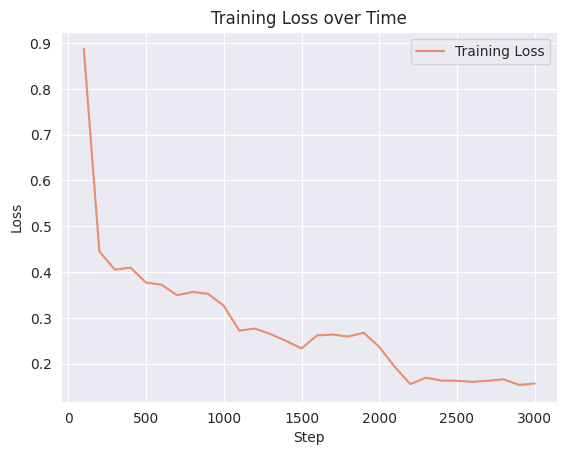

In [111]:
plt.plot(log_train_df['step'], log_train_df['loss'], label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.legend()
plt.show()

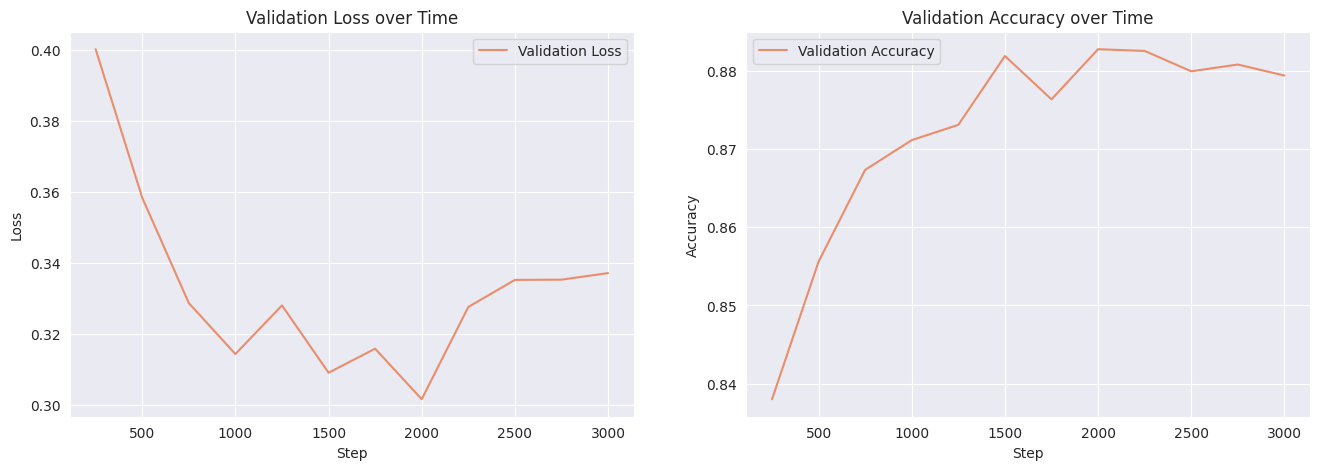

In [112]:
log_eval_df = log_df[log_df['eval_loss'].notna()]
fig, ax = plt.subplots(1,2, figsize = (16, 5))
ax[0].plot(log_eval_df['step'], log_eval_df['eval_loss'], label="Validation Loss")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Loss")
ax[0].set_title("Validation Loss over Time")
ax[0].legend()
ax[1].plot(log_eval_df['step'], log_eval_df['eval_accuracy'], label="Validation Accuracy")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Validation Accuracy over Time")
ax[1].legend()
plt.show()

In [113]:
trainer.save_model()
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


  0%|          | 0/288 [00:00<?, ?it/s]

{'eval_loss': 0.3016800582408905,
 'eval_accuracy': 0.882768361581921,
 'eval_runtime': 23.3964,
 'eval_samples_per_second': 393.393,
 'eval_steps_per_second': 12.31,
 'epoch': 3.0}

In [114]:
preds_bert = trainer.predict(test_dataset)
preds_bert

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


  0%|          | 0/144 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 0.7267302,  6.575944 , -2.6612306, -2.6465876, -2.0884135,
        -2.7577696],
       [ 2.2356298, -2.492775 , -1.8306961, -1.6331725, -2.6250172,
         3.6326149],
       [-2.0342839, -1.199722 , -1.6550688, -2.6003478,  6.934492 ,
        -2.3105316],
       ...,
       [-1.2808805, -2.681793 ,  7.0013533, -2.0313616, -2.4771311,
        -1.5640736],
       [-0.8318941, -2.2720587, -1.6701097,  6.997945 , -2.0157473,
        -1.1836758],
       [-1.3975902, -2.5569136,  7.0384088, -2.1961198, -2.2563963,
        -1.6094879]], dtype=float32), label_ids=array([1, 5, 4, ..., 2, 3, 2]), metrics={'test_loss': 0.29400527477264404, 'test_accuracy': 0.8804867448935245, 'test_runtime': 11.8329, 'test_samples_per_second': 388.916, 'test_steps_per_second': 12.169})

In [115]:
preds_classes_bert = np.argmax(preds_bert[0], axis = 1)
preds_classes_bert

array([1, 5, 4, ..., 2, 3, 2])

                     precision    recall  f1-score   support

  not_cyberbullying       0.72      0.64      0.68       751
           religion       0.98      0.96      0.97       807
                age       0.99      0.97      0.98       757
             gender       0.90      0.92      0.91       801
          ethnicity       1.00      0.99      0.99       839
other_cyberbullying       0.66      0.76      0.71       647

           accuracy                           0.88      4602
          macro avg       0.87      0.87      0.87      4602
       weighted avg       0.88      0.88      0.88      4602



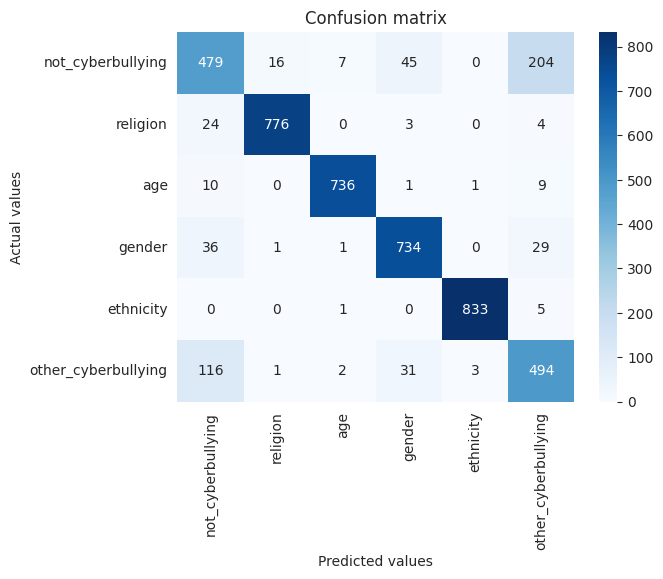

In [116]:
plot_confusion_matrix_and_cl_rep(test_dataset['labels'],preds_classes_bert,label_encodings.keys())

Obviously BERT outperformed all other models having f1 score being almost 100 on ethnicity class, and overall being better predicting the label.

### Misclassified samples

Let's get the misclassified rows to manually check what could be the reason of error

In [117]:
test_dataset

Dataset({
    features: ['tweet_text', 'labels', 'clean_text', 'lemmas', 'token_count', 'input_ids', 'attention_mask'],
    num_rows: 4602
})

In [118]:
texts = []
labels = []

for i in range(len(test_dataset)):
    sample = test_dataset[i]
    texts.append(sample["tweet_text"])
    labels.append(sample["labels"])

df = pd.DataFrame({"text": texts, "label": labels})

In [119]:
df['predicted'] = preds_classes_bert

In [120]:
df

text  label  predicted
0     Who r u stop islamic terrorism in India #Islam...      1          1
1     Being shamed for past relationships is one of ...      5          5
2     Just my school downplaying blatant racism and ...      4          4
3     yes, kinda like that. the title of the movie i...      2          2
4     “@standbythebody: Roxane Gay on Daniel Tosh an...      3          3
...                                                 ...    ...        ...
4597  Kendall Fucking Jenner made a stupid Pepsi ad?...      5          5
4598  Racism is wen u select ur White clothes 2 wash...      4          4
4599  they’re pretty, come from big non profits, and...      2          2
4600  im not trying to side but yeah rape jokes are ...      3          3
4601  It’s a bad one. TLDR of this TikTok: invite a ...      2          2

[4602 rows x 3 columns]

In [121]:
misclassified = df[df['label']!=df['predicted']]
misclassified

text  label  predicted
6     When her hands get sore, she finds another way...      3          0
23    @Sheikh_Times3 How would you kill the terroris...      0          1
24    WTF....#mkr the girls used bought sorbet amd t...      0          3
32    Kat and Andre better fuck off this show quickl...      3          0
37    @GooseNetworkUSA @06JAnk @PatrickOsgood Stupid...      0          5
...                                                 ...    ...        ...
4561       @howxg @CTFleaMarkets http://t.co/oCBCQYL8o5      0          5
4566  NPR asked to speak to me about the wadhwa thin...      0          5
4572  Strongly debating stopping by the IKEA in Port...      0          5
4578     @RonBasler yes. I will be censoring the names.      0          5
4584  RT @Ostrov_A: Sending thoughts of peace to all...      5          0

[550 rows x 3 columns]

In [122]:
from google.colab import files
misclassified.to_excel('misclassified.xlsx', index = False)
files.download("misclassified.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>